In [1]:
import os
import shutil
import sys

# Ορισμός διαδρομών
# input_folder: Ο φάκελος όπου βρίσκεται το dataset (Read-Only στο Kaggle)
# working_folder: Ο φάκελος εργασίας όπου θα αντιγράψουμε τα αρχεία για να κάνουμε αλλαγές
input_folder = '/kaggle/input/pidnet-2/PIDNet'
working_folder = '/kaggle/working/PIDNet'

print("Εκκίνηση διαδικασίας Setup...")

# 1. Καθαρισμός φακέλου εργασίας
# Αν υπάρχει προηγούμενη εγκατάσταση, τη διαγράφουμε για να ξεκινήσουμε καθαρά
if os.path.exists(working_folder):
    shutil.rmtree(working_folder)

# 2. Αντιγραφή αρχείων
# Αντιγράφουμε όλο το project από το input στο working directory
print(f"Αντιγραφή αρχείων από {input_folder}...")
try:
    shutil.copytree(input_folder, working_folder)
except Exception as e:
    print(f"Σφάλμα κατά την αντιγραφή: {e}")
    sys.exit(1)

# 3. Αλλαγή τρέχοντος καταλόγου
# Μεταφέρουμε το python session μέσα στον φάκελο του project
os.chdir(working_folder)

# 4. Εγκατάσταση εξαρτήσεων
# Εγκαθιστούμε βιβλιοθήκες που λείπουν από το default περιβάλλον του Kaggle
print("Εγκατάσταση βιβλιοθηκών...")
os.system('pip install -q tensorboardX yacs termcolor tabulate')

# 5. Διόρθωση αρχείων λίστας (.lst)
# Τα αρχεία train.lst κλπ. έχουν απόλυτα paths που ξεκινάνε με '/' (π.χ. /images/...)
print("Διόρθωση paths στα αρχεία λίστας...")
base_path = 'data/list/camvid'
for filename in ['train.lst', 'val.lst', 'trainval.lst']:
    file_path = os.path.join(base_path, filename)
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            lines = [line.lstrip('/') for line in f]
        with open(file_path, 'w') as f:
            f.writelines(lines)

print("Η διαδικασία Setup ολοκληρώθηκε.")

Εκκίνηση διαδικασίας Setup...
Αντιγραφή αρχείων από /kaggle/input/pidnet-2/PIDNet...
Εγκατάσταση βιβλιοθηκών...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.1 MB/s eta 0:00:00
Διόρθωση paths στα αρχεία λίστας...
Η διαδικασία Setup ολοκληρώθηκε.


In [6]:
import os
import re
import torch
import shutil
import numpy as np

print("Εφαρμογή διορθώσεων κώδικα (συμπεριλαμβανομένου του Label Mapping) και εκκίνηση...")

# Έλεγχος διαθέσιμων GPU
gpu_count = torch.cuda.device_count()
print(f"Ανιχνεύθηκαν {gpu_count} GPUs.")

# -------------------------------------------------------------------------
# PATCH 1: tools/train.py
# -------------------------------------------------------------------------
train_path = 'tools/train.py'
with open(train_path, 'r') as f:
    code = f.read()

code = re.sub(r'if\s+len\(gpus\)\s*!=\s*torch\.cuda\.device_count\(\):', 'if False:', code)

with open(train_path, 'w') as f:
    f.write(code)

# -------------------------------------------------------------------------
# PATCH 2: datasets/base_dataset.py
# -------------------------------------------------------------------------
with open('datasets/base_dataset.py', 'r') as f:
    code = f.read()
code = code.replace('np.int(', 'int(')
with open('datasets/base_dataset.py', 'w') as f:
    f.write(code)

# -------------------------------------------------------------------------
# PATCH 3: datasets/camvid.py
# Προστέθηκε η λογική Mapping για τα χρώματα του CVAT (76->Fire, 24->Smoke)
# -------------------------------------------------------------------------
camvid_code = """
from .base_dataset import BaseDataset
import torch
import numpy as np
import cv2
import os

class CamVid(BaseDataset):
    def __init__(self, root, list_path, num_samples=None, num_classes=4, multi_scale=True, flip=True, ignore_label=255, base_size=960, crop_size=(720, 960), downsample_rate=1, scale_factor=16, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        super(CamVid, self).__init__(ignore_label, base_size, crop_size, scale_factor, mean, std)
        self.root = root
        self.list_path = list_path
        self.num_classes = num_classes
        self.multi_scale = multi_scale
        self.flip = flip
        self.img_list = [line.strip().split() for line in open(root+list_path)]
        self.files = self.read_files()
        self.base_size = base_size
        self.crop_size = crop_size
        self.ignore_label = ignore_label
        self.mean = mean
        self.std = std
        self.scale_factor = scale_factor
        self.downsample_rate = downsample_rate
        self.edge_pad = True 
        self.class_weights = None 

    def read_files(self):
        files = []
        for item in self.img_list:
            if len(item) == 2:
                image_path, label_path = item
                name = os.path.splitext(os.path.basename(item[1]))[0]
                files.append({"img": item[0], "label": item[1], "name": name})
        return files

    def __getitem__(self, index):
        item = self.files[index]
        name = item["name"]
        
        # Φόρτωση εικόνας
        image_path = os.path.join(self.root, 'camvid', item["img"])
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None: 
            raise FileNotFoundError(f"Image not found: {item['img']}")
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Φόρτωση μάσκας
        label_path = os.path.join(self.root, 'camvid', item["label"])
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        label = np.array(label, dtype=np.uint8)

        # --- FIX: ΔΙΟΡΘΩΣΗ ΤΙΜΩΝ (LABEL MAPPING) ---
        # Μετατροπή των τιμών εξαγωγής CVAT στα σωστά Class IDs (0-3)
        # 76 -> Fire (0)
        # 24 -> Smoke (1)
        # 140-180 -> Burnt (2)
        # Υπόλοιπα -> Background (3)
        
        label_fixed = np.zeros_like(label) + 3 # Default: Background
        
        label_fixed[(label >= 70) & (label <= 85)] = 0   # Fire
        label_fixed[(label >= 20) & (label <= 30)] = 1   # Smoke
        label_fixed[(label >= 140) & (label <= 180)] = 2 # Burnt
        
        label = label_fixed.astype(np.uint8)
        # -------------------------------------------

        # Διόρθωση Διαστάσεων (Resize)
        target_h, target_w = self.crop_size
        if image.shape[0] != target_h or image.shape[1] != target_w:
            image = cv2.resize(image, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
        
        if label.shape[0] != target_h or label.shape[1] != target_w:
            label = cv2.resize(label, (target_w, target_h), interpolation=cv2.INTER_NEAREST)

        size = image.shape

        # Εφαρμογή Data Augmentation
        image, label, edge = self.gen_sample(image, label, self.multi_scale, self.flip, edge_pad=False, edge_size=4, city=False)
        
        # Μετατροπή σε Tensors
        image = torch.from_numpy(np.ascontiguousarray(image)).float()
        label = torch.from_numpy(np.ascontiguousarray(label)).long()
        edge = torch.from_numpy(np.ascontiguousarray(edge)).float()
        size = torch.tensor(size)
        
        return image, label, edge, size, name
"""
with open('datasets/camvid.py', 'w') as f: f.write(camvid_code)

# -------------------------------------------------------------------------
# PATCH 4: utils/utils.py
# -------------------------------------------------------------------------
utils_code = """
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os, logging, time, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from configs import config
from pathlib import Path

class FullModel(nn.Module):
  def __init__(self, model, sem_loss, bd_loss):
    super(FullModel, self).__init__()
    self.model = model
    self.sem_loss = sem_loss
    self.bd_loss = bd_loss

  def pixel_acc(self, pred, label):
    _, preds = torch.max(pred, dim=1)
    valid = (label >= 0).long()
    acc_sum = torch.sum(valid * (preds == label).long())
    pixel_sum = torch.sum(valid)
    return acc_sum.float() / (pixel_sum.float() + 1e-10)

  def forward(self, inputs, labels, bd_gt, *args, **kwargs):
    outputs = self.model(inputs, *args, **kwargs)
    h, w = labels.size(1), labels.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=config.MODEL.ALIGN_CORNERS)

    acc  = self.pixel_acc(outputs[1], labels)
    loss_s = self.sem_loss(outputs[1], labels)
    loss_p = self.sem_loss(outputs[0], labels)
    
    loss_b = torch.tensor(0.0).to(inputs.device) 

    loss = loss_s + 0.4 * loss_p
    return torch.unsqueeze(loss,0), outputs[1], acc, [loss_s, loss_b]

class AverageMeter(object):
    def __init__(self): self.reset()
    def reset(self): self.val=0; self.avg=0; self.sum=0; self.count=0
    def update(self, val, n=1): self.val=val; self.sum+=val*n; self.count+=n; self.avg=self.sum/self.count
    def average(self): return self.avg

def create_logger(cfg, cfg_name, phase='train'):
    root_output_dir = Path(cfg.OUTPUT_DIR)
    if not root_output_dir.exists(): root_output_dir.mkdir()
    dataset = cfg.DATASET.DATASET
    model = cfg.MODEL.NAME
    cfg_name = os.path.basename(cfg_name).split('.')[0]
    final_output_dir = root_output_dir / dataset / cfg_name
    final_output_dir.mkdir(parents=True, exist_ok=True)
    time_str = time.strftime('%Y-%m-%d-%H-%M')
    log_file = '{}_{}_{}.log'.format(cfg_name, time_str, phase)
    final_log_file = final_output_dir / log_file
    logging.basicConfig(filename=str(final_log_file), format='%(asctime)-15s %(message)s')
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    console = logging.StreamHandler()
    logging.getLogger('').addHandler(console)
    return logger, str(final_output_dir), str(Path(cfg.LOG_DIR)/dataset/model/(cfg_name+'_'+time.strftime('%Y-%m-%d-%H-%M')))

def get_confusion_matrix(label, pred, size, num_class, ignore=-1):
    output = pred.cpu().numpy().transpose(0, 2, 3, 1)
    seg_pred = np.asarray(np.argmax(output, axis=3), dtype=np.uint8)
    seg_gt = np.asarray(label.cpu().numpy()[:, :size[-2], :size[-1]], dtype=int)
    ignore_index = seg_gt != ignore
    seg_gt = seg_gt[ignore_index]
    seg_pred = seg_pred[ignore_index]
    index = (seg_gt * num_class + seg_pred).astype('int32')
    label_count = np.bincount(index)
    confusion_matrix = np.zeros((num_class, num_class))
    for i_label in range(num_class):
        for i_pred in range(num_class):
            cur_index = i_label * num_class + i_pred
            if cur_index < len(label_count):
                confusion_matrix[i_label, i_pred] = label_count[cur_index]
    return confusion_matrix

def adjust_learning_rate(optimizer, base_lr, max_iters, cur_iters, power=0.9, nbb_mult=10):
    # FIX: Ελέγχουμε αν η πρόοδος είναι αρνητική ΠΡΙΝ την ύψωση σε δύναμη
    progress = 1 - float(cur_iters) / max_iters
    if progress < 0: progress = 0
    
    lr = base_lr * (progress ** power)
    
    # Επιβάλλουμε το κατώτατο όριο
    if lr < 1e-6: 
        lr = 1e-6
    
    optimizer.param_groups[0]['lr'] = lr
    if len(optimizer.param_groups) == 2:
        optimizer.param_groups[1]['lr'] = lr * nbb_mult
    return lr
"""
with open('utils/utils.py', 'w') as f: f.write(utils_code)

# -------------------------------------------------------------------------
# PATCH 5: utils/criterion.py
# -------------------------------------------------------------------------
criterion_code = """
import torch.nn as nn
import torch
import torch.nn.functional as F

class CrossEntropy(nn.Module):
    def __init__(self, ignore_label=255, weight=None):
        super(CrossEntropy, self).__init__()
        self.ignore_label = 255; self.criterion = nn.CrossEntropyLoss(weight=weight, ignore_index=255)
    def forward(self, score, target):
        ph, pw = score.size(2), score.size(3); h, w = target.size(1), target.size(2)
        if ph != h or pw != w: score = F.interpolate(input=score, size=(h, w), mode='bilinear', align_corners=True)
        
        num_classes = score.size(1)
        bad_pixels = (target >= num_classes) & (target != 255)
        if bad_pixels.any():
            target[bad_pixels] = 255
            
        return self.criterion(score, target)

class OhemCrossEntropy(CrossEntropy):
    def __init__(self, ignore_label=-1, thres=0.7, min_kept=100000, weight=None):
        super(OhemCrossEntropy, self).__init__(ignore_label=255, weight=weight)
class BondaryLoss(nn.Module):
    def __init__(self): super(BondaryLoss, self).__init__()
    def forward(self, x, target): return torch.tensor(0.0).to(x.device)
"""
with open('utils/criterion.py', 'w') as f: f.write(criterion_code)

# -------------------------------------------------------------------------
# Ρύθμιση Config και Εκτέλεση
# -------------------------------------------------------------------------
print("Ενημέρωση ρυθμίσεων (Config) για T4 x2 GPUs...")
config_path = 'configs/camvid/pidnet_small_camvid.yaml'
with open(config_path, 'r') as f: cfg = f.read()

# Ορισμός κλάσεων
cfg = re.sub(r'NUM_CLASSES: \d+', 'NUM_CLASSES: 4', cfg)

# Ενεργοποίηση και των δύο καρτών γραφικών (0, 1)
cfg = cfg.replace('GPUS: (0,)', 'GPUS: (0,1)')

# Απενεργοποίηση προχωρημένων λειτουργιών που βαραίνουν την εκπαίδευση
cfg = re.sub(r'SB_WEIGHTS: \d+\.\d+', 'SB_WEIGHTS: 0.0', cfg)
cfg = re.sub(r"PRETRAINED: '.*?'", "PRETRAINED: ''", cfg)
cfg = re.sub(r'USE_OHEM: .*', 'USE_OHEM: false', cfg)

# Απενεργοποίηση Benchmark για αποφυγή σφαλμάτων μνήμης σε T4 hardware
cfg = cfg.replace('BENCHMARK: true', 'BENCHMARK: false')
cfg = cfg.replace('DETERMINISTIC: false', 'DETERMINISTIC: true')

with open(config_path, 'w') as f: f.write(cfg)

# Καθαρισμός προηγούμενων αποτελεσμάτων
if os.path.exists('output'):
    shutil.rmtree('output')

print("Έναρξη εκπαίδευσης...")

# Εκτέλεση του train.py με παραμέτρους
# Χρησιμοποιούμε 2 Workers για ταχύτερη φόρτωση δεδομένων.
os.system('python tools/train.py --cfg configs/camvid/pidnet_small_camvid.yaml TRAIN.BATCH_SIZE_PER_GPU 4 TRAIN.LR 0.01 TRAIN.OPTIMIZER sgd WORKERS 2 TEST.IMAGE_SIZE "[960, 704]" OUTPUT_DIR output')

Εφαρμογή διορθώσεων κώδικα (συμπεριλαμβανομένου του Label Mapping) και εκκίνηση...
Ανιχνεύθηκαν 2 GPUs.
Ενημέρωση ρυθμίσεων (Config) για T4 x2 GPUs...
Έναρξη εκπαίδευσης...


INFO:root:Namespace(cfg='configs/camvid/pidnet_small_camvid.yaml', seed=304, opts=['TRAIN.BATCH_SIZE_PER_GPU', '4', 'TRAIN.LR', '0.01', 'TRAIN.OPTIMIZER', 'sgd', 'WORKERS', '2', 'TEST.IMAGE_SIZE', '[960, 704]', 'OUTPUT_DIR', 'output'])
Namespace(cfg='configs/camvid/pidnet_small_camvid.yaml', seed=304, opts=['TRAIN.BATCH_SIZE_PER_GPU', '4', 'TRAIN.LR', '0.01', 'TRAIN.OPTIMIZER', 'sgd', 'WORKERS', '2', 'TEST.IMAGE_SIZE', '[960, 704]', 'OUTPUT_DIR', 'output'])
INFO:root:AUTO_RESUME: False
CUDNN:
  BENCHMARK: False
  DETERMINISTIC: True
  ENABLED: True
DATASET:
  DATASET: camvid
  EXTRA_TRAIN_SET: 
  NUM_CLASSES: 4
  ROOT: data/
  TEST_SET: list/camvid/val.lst
  TRAIN_SET: list/camvid/trainval.lst
GPUS: (0, 1)
LOG_DIR: log
LOSS:
  BALANCE_WEIGHTS: [0.4, 1.0]
  CLASS_BALANCE: False
  OHEMKEEP: 131072
  OHEMTHRES: 0.9
  SB_WEIGHTS: 0.0
  USE_OHEM: False
MODEL:
  ALIGN_CORNERS: True
  NAME: pidnet_s
  NUM_OUTPUTS: 2
  PRETRAINED: 
OUTPUT_DIR: output
PIN_MEMORY: True
PRINT_FREQ: 10
TEST:
  BAS

Seeding with 304
No pretrained model path provided. Training from scratch.


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
INFO:root:Epoch: [0/200] Iter:[0/148], Time: 3.33, lr: [0.01], Loss: 4.039221, Acc:0.298241, Semantic loss: 2.935462, BCE loss: 0.000000, SB loss: 1.103759
Epoch: [0/200] Iter:[0/148], Time: 3.33, lr: [0.01], Loss: 4.039221, Acc:0.298241, Semantic loss: 2.935462, BCE loss: 0.000000, SB loss: 1.103759
INFO:root:Epoch: [0/200] Iter:[10/148], Time: 0.85, lr: [0.009996959408092613], Loss: 3.443697, Acc:0.397377, Semantic loss: 2.477702, BCE loss: 0.000000, SB loss: 0.965995
Epoch: [0/200] Iter:[10/148], Time: 0.85, lr: [0.009996959408092613], Loss: 3.443697, Acc:0.397377, Semantic loss: 2.477702, BCE loss: 0.000000, SB loss: 0.965995
INFO:root:Epoch: [0/200] Iter:[20/148], Time: 0.74, lr: [0.009993918713426074], Loss: 2.498138, Acc:0.453748, Semantic loss: 1.770928, BC

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [1/200] Iter:[0/148], Time: 1.70, lr: [0.00995498872932069], Loss: 1.144764, Acc:0.621187, Semantic loss: 0.800391, BCE loss: 0.000000, SB loss: 0.344373
Epoch: [1/200] Iter:[0/148], Time: 1.70, lr: [0.00995498872932069], Loss: 1.144764, Acc:0.621187, Semantic loss: 0.800391, BCE loss: 0.000000, SB loss: 0.344373
INFO:root:Epoch: [1/200] Iter:[10/148], Time: 0.75, lr: [0.009951946612663562], Loss: 1.063791, Acc:0.583458, Semantic loss: 0.738533, BCE loss: 0.000000, SB loss: 0.325258
Epoch: [1/200] Iter:[10/148], Time: 0.75, lr: [0.009951946612663562], Loss: 1.063791, Acc:0.583458, Semantic loss: 0.738533, BCE loss: 0.000000, SB loss: 0.325258
INFO:root:Epoch: [1/200] Iter:[20/148], Time: 0.70, lr: [0.009948904392678927], Loss: 1.079089, Acc:0.589946, Semantic loss: 0.746226, BCE loss: 0.000000, SB loss: 0.332863
Epoch: [1/200] Iter:[20/148], Time: 0.70, lr: [0.009948904392678927], Loss: 1.079089, Acc:0.589946, Semantic loss: 0.746226, BCE loss: 0.000000, SB loss: 0.332

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [6/200] Iter:[0/148], Time: 1.38, lr: [0.009729590473501306], Loss: 0.538042, Acc:0.608898, Semantic loss: 0.350085, BCE loss: 0.000000, SB loss: 0.187957
Epoch: [6/200] Iter:[0/148], Time: 1.38, lr: [0.009729590473501306], Loss: 0.538042, Acc:0.608898, Semantic loss: 0.350085, BCE loss: 0.000000, SB loss: 0.187957
INFO:root:Epoch: [6/200] Iter:[10/148], Time: 0.73, lr: [0.009726540604479146], Loss: 0.803966, Acc:0.641263, Semantic loss: 0.545046, BCE loss: 0.000000, SB loss: 0.258920
Epoch: [6/200] Iter:[10/148], Time: 0.73, lr: [0.009726540604479146], Loss: 0.803966, Acc:0.641263, Semantic loss: 0.545046, BCE loss: 0.000000, SB loss: 0.258920
INFO:root:Epoch: [6/200] Iter:[20/148], Time: 0.68, lr: [0.009723490629195326], Loss: 0.917324, Acc:0.627156, Semantic loss: 0.624983, BCE loss: 0.000000, SB loss: 0.292341
Epoch: [6/200] Iter:[20/148], Time: 0.68, lr: [0.009723490629195326], Loss: 0.917324, Acc:0.627156, Semantic loss: 0.624983, BCE loss: 0.000000, SB loss: 0.2

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [11/200] Iter:[0/148], Time: 1.54, lr: [0.009503610477363587], Loss: 0.737304, Acc:0.640305, Semantic loss: 0.474670, BCE loss: 0.000000, SB loss: 0.262634
Epoch: [11/200] Iter:[0/148], Time: 1.54, lr: [0.009503610477363587], Loss: 0.737304, Acc:0.640305, Semantic loss: 0.474670, BCE loss: 0.000000, SB loss: 0.262634
INFO:root:Epoch: [11/200] Iter:[10/148], Time: 0.73, lr: [0.009500552632969495], Loss: 0.785040, Acc:0.655015, Semantic loss: 0.535644, BCE loss: 0.000000, SB loss: 0.249397
Epoch: [11/200] Iter:[10/148], Time: 0.73, lr: [0.009500552632969495], Loss: 0.785040, Acc:0.655015, Semantic loss: 0.535644, BCE loss: 0.000000, SB loss: 0.249397
INFO:root:Epoch: [11/200] Iter:[20/148], Time: 0.68, lr: [0.009497494679216302], Loss: 0.839349, Acc:0.651644, Semantic loss: 0.571130, BCE loss: 0.000000, SB loss: 0.268219
Epoch: [11/200] Iter:[20/148], Time: 0.68, lr: [0.009497494679216302], Loss: 0.839349, Acc:0.651644, Semantic loss: 0.571130, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [16/200] Iter:[0/148], Time: 1.53, lr: [0.009277031785633282], Loss: 0.538469, Acc:0.718959, Semantic loss: 0.356069, BCE loss: 0.000000, SB loss: 0.182400
Epoch: [16/200] Iter:[0/148], Time: 1.53, lr: [0.009277031785633282], Loss: 0.538469, Acc:0.718959, Semantic loss: 0.356069, BCE loss: 0.000000, SB loss: 0.182400
INFO:root:Epoch: [16/200] Iter:[10/148], Time: 0.73, lr: [0.009273965730283815], Loss: 0.664072, Acc:0.722872, Semantic loss: 0.429709, BCE loss: 0.000000, SB loss: 0.234363
Epoch: [16/200] Iter:[10/148], Time: 0.73, lr: [0.009273965730283815], Loss: 0.664072, Acc:0.722872, Semantic loss: 0.429709, BCE loss: 0.000000, SB loss: 0.234363
INFO:root:Epoch: [16/200] Iter:[20/148], Time: 0.69, lr: [0.009270899562300754], Loss: 0.682268, Acc:0.694737, Semantic loss: 0.441631, BCE loss: 0.000000, SB loss: 0.240637
Epoch: [16/200] Iter:[20/148], Time: 0.69, lr: [0.009270899562300754], Loss: 0.682268, Acc:0.694737, Semantic loss: 0.441631, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [21/200] Iter:[0/148], Time: 1.57, lr: [0.009049836473820612], Loss: 0.574092, Acc:0.862139, Semantic loss: 0.355945, BCE loss: 0.000000, SB loss: 0.218148
Epoch: [21/200] Iter:[0/148], Time: 1.57, lr: [0.009049836473820612], Loss: 0.574092, Acc:0.862139, Semantic loss: 0.355945, BCE loss: 0.000000, SB loss: 0.218148
INFO:root:Epoch: [21/200] Iter:[10/148], Time: 0.75, lr: [0.009046761958279845], Loss: 0.667777, Acc:0.706455, Semantic loss: 0.428562, BCE loss: 0.000000, SB loss: 0.239215
Epoch: [21/200] Iter:[10/148], Time: 0.75, lr: [0.009046761958279845], Loss: 0.667777, Acc:0.706455, Semantic loss: 0.428562, BCE loss: 0.000000, SB loss: 0.239215
INFO:root:Epoch: [21/200] Iter:[20/148], Time: 0.69, lr: [0.009043687326638572], Loss: 0.673490, Acc:0.689542, Semantic loss: 0.443785, BCE loss: 0.000000, SB loss: 0.229704
Epoch: [21/200] Iter:[20/148], Time: 0.69, lr: [0.009043687326638572], Loss: 0.673490, Acc:0.689542, Semantic loss: 0.443785, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [22/200] Iter:[0/148], Time: 1.42, lr: [0.00900432176656329], Loss: 0.599907, Acc:0.707668, Semantic loss: 0.405614, BCE loss: 0.000000, SB loss: 0.194293
Epoch: [22/200] Iter:[0/148], Time: 1.42, lr: [0.00900432176656329], Loss: 0.599907, Acc:0.707668, Semantic loss: 0.405614, BCE loss: 0.000000, SB loss: 0.194293
INFO:root:Epoch: [22/200] Iter:[10/148], Time: 0.73, lr: [0.009001245527791525], Loss: 0.767332, Acc:0.660653, Semantic loss: 0.509404, BCE loss: 0.000000, SB loss: 0.257928
Epoch: [22/200] Iter:[10/148], Time: 0.73, lr: [0.009001245527791525], Loss: 0.767332, Acc:0.660653, Semantic loss: 0.509404, BCE loss: 0.000000, SB loss: 0.257928
INFO:root:Epoch: [22/200] Iter:[20/148], Time: 0.69, lr: [0.008998169172201302], Loss: 0.677904, Acc:0.692021, Semantic loss: 0.447369, BCE loss: 0.000000, SB loss: 0.230534
Epoch: [22/200] Iter:[20/148], Time: 0.69, lr: [0.008998169172201302], Loss: 0.677904, Acc:0.692021, Semantic loss: 0.447369, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [23/200] Iter:[0/148], Time: 1.34, lr: [0.008958781481920454], Loss: 0.461923, Acc:0.758903, Semantic loss: 0.291054, BCE loss: 0.000000, SB loss: 0.170869
Epoch: [23/200] Iter:[0/148], Time: 1.34, lr: [0.008958781481920454], Loss: 0.461923, Acc:0.758903, Semantic loss: 0.291054, BCE loss: 0.000000, SB loss: 0.170869
INFO:root:Epoch: [23/200] Iter:[10/148], Time: 0.71, lr: [0.008955703509233413], Loss: 0.667751, Acc:0.675245, Semantic loss: 0.442857, BCE loss: 0.000000, SB loss: 0.224894
Epoch: [23/200] Iter:[10/148], Time: 0.71, lr: [0.008955703509233413], Loss: 0.667751, Acc:0.675245, Semantic loss: 0.442857, BCE loss: 0.000000, SB loss: 0.224894
INFO:root:Epoch: [23/200] Iter:[20/148], Time: 0.67, lr: [0.008952625419001443], Loss: 0.648322, Acc:0.692490, Semantic loss: 0.429004, BCE loss: 0.000000, SB loss: 0.219319
Epoch: [23/200] Iter:[20/148], Time: 0.67, lr: [0.008952625419001443], Loss: 0.648322, Acc:0.692490, Semantic loss: 0.429004, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [24/200] Iter:[0/148], Time: 1.52, lr: [0.00891321546089], Loss: 0.337972, Acc:0.609743, Semantic loss: 0.203049, BCE loss: 0.000000, SB loss: 0.134922
Epoch: [24/200] Iter:[0/148], Time: 1.52, lr: [0.00891321546089], Loss: 0.337972, Acc:0.609743, Semantic loss: 0.203049, BCE loss: 0.000000, SB loss: 0.134922
INFO:root:Epoch: [24/200] Iter:[10/148], Time: 0.73, lr: [0.008910135743476228], Loss: 0.584587, Acc:0.709304, Semantic loss: 0.361140, BCE loss: 0.000000, SB loss: 0.223447
Epoch: [24/200] Iter:[10/148], Time: 0.73, lr: [0.008910135743476228], Loss: 0.584587, Acc:0.709304, Semantic loss: 0.361140, BCE loss: 0.000000, SB loss: 0.223447
INFO:root:Epoch: [24/200] Iter:[20/148], Time: 0.71, lr: [0.008907055907782376], Loss: 0.599695, Acc:0.711798, Semantic loss: 0.376241, BCE loss: 0.000000, SB loss: 0.223453
Epoch: [24/200] Iter:[20/148], Time: 0.71, lr: [0.008907055907782376], Loss: 0.599695, Acc:0.711798, Semantic loss: 0.376241, BCE loss: 0.000000, SB loss: 0.223

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [25/200] Iter:[0/148], Time: 1.56, lr: [0.008867623542572074], Loss: 0.776704, Acc:0.704198, Semantic loss: 0.568109, BCE loss: 0.000000, SB loss: 0.208595
Epoch: [25/200] Iter:[0/148], Time: 1.56, lr: [0.008867623542572074], Loss: 0.776704, Acc:0.704198, Semantic loss: 0.568109, BCE loss: 0.000000, SB loss: 0.208595
INFO:root:Epoch: [25/200] Iter:[10/148], Time: 0.74, lr: [0.00886454206949068], Loss: 0.787631, Acc:0.650525, Semantic loss: 0.542005, BCE loss: 0.000000, SB loss: 0.245626
Epoch: [25/200] Iter:[10/148], Time: 0.74, lr: [0.00886454206949068], Loss: 0.787631, Acc:0.650525, Semantic loss: 0.542005, BCE loss: 0.000000, SB loss: 0.245626
INFO:root:Epoch: [25/200] Iter:[20/148], Time: 0.69, lr: [0.008861460477385235], Loss: 0.761673, Acc:0.655037, Semantic loss: 0.518673, BCE loss: 0.000000, SB loss: 0.243001
Epoch: [25/200] Iter:[20/148], Time: 0.69, lr: [0.008861460477385235], Loss: 0.761673, Acc:0.655037, Semantic loss: 0.518673, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [26/200] Iter:[0/148], Time: 1.55, lr: [0.008822005564135439], Loss: 0.496685, Acc:0.763152, Semantic loss: 0.309374, BCE loss: 0.000000, SB loss: 0.187311
Epoch: [26/200] Iter:[0/148], Time: 1.55, lr: [0.008822005564135439], Loss: 0.496685, Acc:0.763152, Semantic loss: 0.309374, BCE loss: 0.000000, SB loss: 0.187311
INFO:root:Epoch: [26/200] Iter:[10/148], Time: 0.75, lr: [0.008818922324313805], Loss: 0.549619, Acc:0.724362, Semantic loss: 0.347115, BCE loss: 0.000000, SB loss: 0.202504
Epoch: [26/200] Iter:[10/148], Time: 0.75, lr: [0.008818922324313805], Loss: 0.549619, Acc:0.724362, Semantic loss: 0.347115, BCE loss: 0.000000, SB loss: 0.202504
INFO:root:Epoch: [26/200] Iter:[20/148], Time: 0.72, lr: [0.00881583896471516], Loss: 0.545482, Acc:0.721699, Semantic loss: 0.343267, BCE loss: 0.000000, SB loss: 0.202216
Epoch: [26/200] Iter:[20/148], Time: 0.72, lr: [0.00881583896471516], Loss: 0.545482, Acc:0.721699, Semantic loss: 0.343267, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [27/200] Iter:[0/148], Time: 1.41, lr: [0.00877636136078306], Loss: 0.566016, Acc:0.774235, Semantic loss: 0.378893, BCE loss: 0.000000, SB loss: 0.187123
Epoch: [27/200] Iter:[0/148], Time: 1.41, lr: [0.00877636136078306], Loss: 0.566016, Acc:0.774235, Semantic loss: 0.378893, BCE loss: 0.000000, SB loss: 0.187123
INFO:root:Epoch: [27/200] Iter:[10/148], Time: 0.72, lr: [0.00877327634301448], Loss: 0.673651, Acc:0.691119, Semantic loss: 0.446325, BCE loss: 0.000000, SB loss: 0.227327
Epoch: [27/200] Iter:[10/148], Time: 0.72, lr: [0.00877327634301448], Loss: 0.673651, Acc:0.691119, Semantic loss: 0.446325, BCE loss: 0.000000, SB loss: 0.227327
INFO:root:Epoch: [27/200] Iter:[20/148], Time: 0.69, lr: [0.008770191204706783], Loss: 0.614681, Acc:0.724041, Semantic loss: 0.401517, BCE loss: 0.000000, SB loss: 0.213163
Epoch: [27/200] Iter:[20/148], Time: 0.69, lr: [0.008770191204706783], Loss: 0.614681, Acc:0.724041, Semantic loss: 0.401517, BCE loss: 0.000000, SB loss: 0

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [28/200] Iter:[0/148], Time: 1.74, lr: [0.00873069076571686], Loss: 0.550312, Acc:0.820064, Semantic loss: 0.348079, BCE loss: 0.000000, SB loss: 0.202234
Epoch: [28/200] Iter:[0/148], Time: 1.74, lr: [0.00873069076571686], Loss: 0.550312, Acc:0.820064, Semantic loss: 0.348079, BCE loss: 0.000000, SB loss: 0.202234
INFO:root:Epoch: [28/200] Iter:[10/148], Time: 0.79, lr: [0.00872760395865813], Loss: 0.663151, Acc:0.731165, Semantic loss: 0.423051, BCE loss: 0.000000, SB loss: 0.240100
Epoch: [28/200] Iter:[10/148], Time: 0.79, lr: [0.00872760395865813], Loss: 0.663151, Acc:0.731165, Semantic loss: 0.423051, BCE loss: 0.000000, SB loss: 0.240100
INFO:root:Epoch: [28/200] Iter:[20/148], Time: 0.72, lr: [0.008724517030288868], Loss: 0.645053, Acc:0.734483, Semantic loss: 0.415811, BCE loss: 0.000000, SB loss: 0.229242
Epoch: [28/200] Iter:[20/148], Time: 0.72, lr: [0.008724517030288868], Loss: 0.645053, Acc:0.734483, Semantic loss: 0.415811, BCE loss: 0.000000, SB loss: 0

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [29/200] Iter:[0/148], Time: 1.54, lr: [0.008684993610101652], Loss: 0.578863, Acc:0.590834, Semantic loss: 0.379944, BCE loss: 0.000000, SB loss: 0.198919
Epoch: [29/200] Iter:[0/148], Time: 1.54, lr: [0.008684993610101652], Loss: 0.578863, Acc:0.590834, Semantic loss: 0.379944, BCE loss: 0.000000, SB loss: 0.198919
INFO:root:Epoch: [29/200] Iter:[10/148], Time: 0.74, lr: [0.008681905002270606], Loss: 0.598889, Acc:0.718650, Semantic loss: 0.383776, BCE loss: 0.000000, SB loss: 0.215113
Epoch: [29/200] Iter:[10/148], Time: 0.74, lr: [0.008681905002270606], Loss: 0.598889, Acc:0.718650, Semantic loss: 0.383776, BCE loss: 0.000000, SB loss: 0.215113
INFO:root:Epoch: [29/200] Iter:[20/148], Time: 0.69, lr: [0.008678816272348133], Loss: 0.558929, Acc:0.716587, Semantic loss: 0.357548, BCE loss: 0.000000, SB loss: 0.201381
Epoch: [29/200] Iter:[20/148], Time: 0.69, lr: [0.008678816272348133], Loss: 0.558929, Acc:0.716587, Semantic loss: 0.357548, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [30/200] Iter:[0/148], Time: 1.48, lr: [0.008639269723028191], Loss: 1.018207, Acc:0.610377, Semantic loss: 0.697589, BCE loss: 0.000000, SB loss: 0.320619
Epoch: [30/200] Iter:[0/148], Time: 1.48, lr: [0.008639269723028191], Loss: 1.018207, Acc:0.610377, Semantic loss: 0.697589, BCE loss: 0.000000, SB loss: 0.320619
INFO:root:Epoch: [30/200] Iter:[10/148], Time: 0.77, lr: [0.008636179302801169], Loss: 0.580950, Acc:0.738953, Semantic loss: 0.379198, BCE loss: 0.000000, SB loss: 0.201752
Epoch: [30/200] Iter:[10/148], Time: 0.77, lr: [0.008636179302801169], Loss: 0.580950, Acc:0.738953, Semantic loss: 0.379198, BCE loss: 0.000000, SB loss: 0.201752
INFO:root:Epoch: [30/200] Iter:[20/148], Time: 0.71, lr: [0.008633088759692167], Loss: 0.572549, Acc:0.736242, Semantic loss: 0.360447, BCE loss: 0.000000, SB loss: 0.212102
Epoch: [30/200] Iter:[20/148], Time: 0.71, lr: [0.008633088759692167], Loss: 0.572549, Acc:0.736242, Semantic loss: 0.360447, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [31/200] Iter:[0/148], Time: 1.63, lr: [0.008593518931475346], Loss: 0.482776, Acc:0.795820, Semantic loss: 0.320850, BCE loss: 0.000000, SB loss: 0.161925
Epoch: [31/200] Iter:[0/148], Time: 1.63, lr: [0.008593518931475346], Loss: 0.482776, Acc:0.795820, Semantic loss: 0.320850, BCE loss: 0.000000, SB loss: 0.161925
INFO:root:Epoch: [31/200] Iter:[10/148], Time: 0.75, lr: [0.008590426687084604], Loss: 0.614945, Acc:0.726810, Semantic loss: 0.403181, BCE loss: 0.000000, SB loss: 0.211764
Epoch: [31/200] Iter:[10/148], Time: 0.75, lr: [0.008590426687084604], Loss: 0.614945, Acc:0.726810, Semantic loss: 0.403181, BCE loss: 0.000000, SB loss: 0.211764
INFO:root:Epoch: [31/200] Iter:[20/148], Time: 0.70, lr: [0.008587334319011503], Loss: 0.581909, Acc:0.741194, Semantic loss: 0.367924, BCE loss: 0.000000, SB loss: 0.213985
Epoch: [31/200] Iter:[20/148], Time: 0.70, lr: [0.008587334319011503], Loss: 0.581909, Acc:0.741194, Semantic loss: 0.367924, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [32/200] Iter:[0/148], Time: 1.51, lr: [0.008547741060271343], Loss: 0.579829, Acc:0.709539, Semantic loss: 0.395256, BCE loss: 0.000000, SB loss: 0.184573
Epoch: [32/200] Iter:[0/148], Time: 1.51, lr: [0.008547741060271343], Loss: 0.579829, Acc:0.709539, Semantic loss: 0.395256, BCE loss: 0.000000, SB loss: 0.184573
INFO:root:Epoch: [32/200] Iter:[10/148], Time: 0.73, lr: [0.008544646979802404], Loss: 0.723910, Acc:0.695399, Semantic loss: 0.478408, BCE loss: 0.000000, SB loss: 0.245501
Epoch: [32/200] Iter:[10/148], Time: 0.73, lr: [0.008544646979802404], Loss: 0.723910, Acc:0.695399, Semantic loss: 0.478408, BCE loss: 0.000000, SB loss: 0.245501
INFO:root:Epoch: [32/200] Iter:[20/148], Time: 0.69, lr: [0.008541552774840713], Loss: 0.721902, Acc:0.686516, Semantic loss: 0.472378, BCE loss: 0.000000, SB loss: 0.249524
Epoch: [32/200] Iter:[20/148], Time: 0.69, lr: [0.008541552774840713], Loss: 0.721902, Acc:0.686516, Semantic loss: 0.472378, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [33/200] Iter:[0/148], Time: 1.64, lr: [0.008501935932054073], Loss: 0.543752, Acc:0.775511, Semantic loss: 0.345048, BCE loss: 0.000000, SB loss: 0.198705
Epoch: [33/200] Iter:[0/148], Time: 1.64, lr: [0.008501935932054073], Loss: 0.543752, Acc:0.775511, Semantic loss: 0.345048, BCE loss: 0.000000, SB loss: 0.198705
INFO:root:Epoch: [33/200] Iter:[10/148], Time: 0.75, lr: [0.008498840003443005], Loss: 0.526724, Acc:0.753909, Semantic loss: 0.327564, BCE loss: 0.000000, SB loss: 0.199160
Epoch: [33/200] Iter:[10/148], Time: 0.75, lr: [0.008498840003443005], Loss: 0.526724, Acc:0.753909, Semantic loss: 0.327564, BCE loss: 0.000000, SB loss: 0.199160
INFO:root:Epoch: [33/200] Iter:[20/148], Time: 0.69, lr: [0.0084957439495186], Loss: 0.612471, Acc:0.720707, Semantic loss: 0.396525, BCE loss: 0.000000, SB loss: 0.215947
Epoch: [33/200] Iter:[20/148], Time: 0.69, lr: [0.0084957439495186], Loss: 0.612471, Acc:0.720707, Semantic loss: 0.396525, BCE loss: 0.000000, SB loss: 0

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [34/200] Iter:[0/148], Time: 1.47, lr: [0.00845610336723042], Loss: 0.645133, Acc:0.724068, Semantic loss: 0.429250, BCE loss: 0.000000, SB loss: 0.215883
Epoch: [34/200] Iter:[0/148], Time: 1.47, lr: [0.00845610336723042], Loss: 0.645133, Acc:0.724068, Semantic loss: 0.429250, BCE loss: 0.000000, SB loss: 0.215883
INFO:root:Epoch: [34/200] Iter:[10/148], Time: 0.73, lr: [0.00845300557826106], Loss: 0.511450, Acc:0.729999, Semantic loss: 0.321302, BCE loss: 0.000000, SB loss: 0.190148
Epoch: [34/200] Iter:[10/148], Time: 0.73, lr: [0.00845300557826106], Loss: 0.511450, Acc:0.729999, Semantic loss: 0.321302, BCE loss: 0.000000, SB loss: 0.190148
INFO:root:Epoch: [34/200] Iter:[20/148], Time: 0.69, lr: [0.008449907663147382], Loss: 0.581683, Acc:0.717452, Semantic loss: 0.374803, BCE loss: 0.000000, SB loss: 0.206880
Epoch: [34/200] Iter:[20/148], Time: 0.69, lr: [0.008449907663147382], Loss: 0.581683, Acc:0.717452, Semantic loss: 0.374803, BCE loss: 0.000000, SB loss: 0

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [35/200] Iter:[0/148], Time: 1.37, lr: [0.008410243183934575], Loss: 0.512001, Acc:0.767520, Semantic loss: 0.339805, BCE loss: 0.000000, SB loss: 0.172196
Epoch: [35/200] Iter:[0/148], Time: 1.37, lr: [0.008410243183934575], Loss: 0.512001, Acc:0.767520, Semantic loss: 0.339805, BCE loss: 0.000000, SB loss: 0.172196
INFO:root:Epoch: [35/200] Iter:[10/148], Time: 0.72, lr: [0.00840714352223567], Loss: 0.595222, Acc:0.748270, Semantic loss: 0.377089, BCE loss: 0.000000, SB loss: 0.218133
Epoch: [35/200] Iter:[10/148], Time: 0.72, lr: [0.00840714352223567], Loss: 0.595222, Acc:0.748270, Semantic loss: 0.377089, BCE loss: 0.000000, SB loss: 0.218133
INFO:root:Epoch: [35/200] Iter:[20/148], Time: 0.68, lr: [0.008404043733550887], Loss: 0.562997, Acc:0.731004, Semantic loss: 0.350946, BCE loss: 0.000000, SB loss: 0.212051
Epoch: [35/200] Iter:[20/148], Time: 0.68, lr: [0.008404043733550887], Loss: 0.562997, Acc:0.731004, Semantic loss: 0.350946, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [36/200] Iter:[0/148], Time: 1.59, lr: [0.008364355197985339], Loss: 0.566887, Acc:0.703872, Semantic loss: 0.392124, BCE loss: 0.000000, SB loss: 0.174763
Epoch: [36/200] Iter:[0/148], Time: 1.59, lr: [0.008364355197985339], Loss: 0.566887, Acc:0.703872, Semantic loss: 0.392124, BCE loss: 0.000000, SB loss: 0.174763
INFO:root:Epoch: [36/200] Iter:[10/148], Time: 0.74, lr: [0.008361253651027621], Loss: 0.553120, Acc:0.674200, Semantic loss: 0.359310, BCE loss: 0.000000, SB loss: 0.193810
Epoch: [36/200] Iter:[10/148], Time: 0.74, lr: [0.008361253651027621], Loss: 0.553120, Acc:0.674200, Semantic loss: 0.359310, BCE loss: 0.000000, SB loss: 0.193810
INFO:root:Epoch: [36/200] Iter:[20/148], Time: 0.69, lr: [0.008358151976231682], Loss: 0.531742, Acc:0.723992, Semantic loss: 0.341797, BCE loss: 0.000000, SB loss: 0.189946
Epoch: [36/200] Iter:[20/148], Time: 0.69, lr: [0.008358151976231682], Loss: 0.531742, Acc:0.723992, Semantic loss: 0.341797, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [37/200] Iter:[0/148], Time: 1.43, lr: [0.008318439222842327], Loss: 0.458920, Acc:0.663829, Semantic loss: 0.275500, BCE loss: 0.000000, SB loss: 0.183420
Epoch: [37/200] Iter:[0/148], Time: 1.43, lr: [0.008318439222842327], Loss: 0.458920, Acc:0.663829, Semantic loss: 0.275500, BCE loss: 0.000000, SB loss: 0.183420
INFO:root:Epoch: [37/200] Iter:[10/148], Time: 0.73, lr: [0.008315335777935522], Loss: 0.518298, Acc:0.713184, Semantic loss: 0.327485, BCE loss: 0.000000, SB loss: 0.190813
Epoch: [37/200] Iter:[10/148], Time: 0.73, lr: [0.008315335777935522], Loss: 0.518298, Acc:0.713184, Semantic loss: 0.327485, BCE loss: 0.000000, SB loss: 0.190813
INFO:root:Epoch: [37/200] Iter:[20/148], Time: 0.69, lr: [0.00831223220432716], Loss: 0.497516, Acc:0.736964, Semantic loss: 0.309526, BCE loss: 0.000000, SB loss: 0.187990
Epoch: [37/200] Iter:[20/148], Time: 0.69, lr: [0.00831223220432716], Loss: 0.497516, Acc:0.736964, Semantic loss: 0.309526, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [38/200] Iter:[0/148], Time: 1.53, lr: [0.008272495069561094], Loss: 0.340897, Acc:0.805605, Semantic loss: 0.216652, BCE loss: 0.000000, SB loss: 0.124245
Epoch: [38/200] Iter:[0/148], Time: 1.53, lr: [0.008272495069561094], Loss: 0.340897, Acc:0.805605, Semantic loss: 0.216652, BCE loss: 0.000000, SB loss: 0.124245
INFO:root:Epoch: [38/200] Iter:[10/148], Time: 0.75, lr: [0.008269389713850842], Loss: 0.568877, Acc:0.726844, Semantic loss: 0.375121, BCE loss: 0.000000, SB loss: 0.193756
Epoch: [38/200] Iter:[10/148], Time: 0.75, lr: [0.008269389713850842], Loss: 0.568877, Acc:0.726844, Semantic loss: 0.375121, BCE loss: 0.000000, SB loss: 0.193756
INFO:root:Epoch: [38/200] Iter:[20/148], Time: 0.70, lr: [0.008266284228564498], Loss: 0.565971, Acc:0.730011, Semantic loss: 0.368357, BCE loss: 0.000000, SB loss: 0.197614
Epoch: [38/200] Iter:[20/148], Time: 0.70, lr: [0.008266284228564498], Loss: 0.565971, Acc:0.730011, Semantic loss: 0.368357, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [39/200] Iter:[0/148], Time: 1.53, lr: [0.008226522546747113], Loss: 0.543937, Acc:0.805058, Semantic loss: 0.319851, BCE loss: 0.000000, SB loss: 0.224086
Epoch: [39/200] Iter:[0/148], Time: 1.53, lr: [0.008226522546747113], Loss: 0.543937, Acc:0.805058, Semantic loss: 0.319851, BCE loss: 0.000000, SB loss: 0.224086
INFO:root:Epoch: [39/200] Iter:[10/148], Time: 0.74, lr: [0.008223415267211818], Loss: 0.552527, Acc:0.738592, Semantic loss: 0.362281, BCE loss: 0.000000, SB loss: 0.190245
Epoch: [39/200] Iter:[10/148], Time: 0.74, lr: [0.008223415267211818], Loss: 0.552527, Acc:0.738592, Semantic loss: 0.362281, BCE loss: 0.000000, SB loss: 0.190245
INFO:root:Epoch: [39/200] Iter:[20/148], Time: 0.70, lr: [0.008220307857214483], Loss: 0.520398, Acc:0.752775, Semantic loss: 0.329661, BCE loss: 0.000000, SB loss: 0.190738
Epoch: [39/200] Iter:[20/148], Time: 0.70, lr: [0.008220307857214483], Loss: 0.520398, Acc:0.752775, Semantic loss: 0.329661, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [40/200] Iter:[0/148], Time: 1.60, lr: [0.008180521460508584], Loss: 0.764995, Acc:0.705501, Semantic loss: 0.498493, BCE loss: 0.000000, SB loss: 0.266502
Epoch: [40/200] Iter:[0/148], Time: 1.60, lr: [0.008180521460508584], Loss: 0.764995, Acc:0.705501, Semantic loss: 0.498493, BCE loss: 0.000000, SB loss: 0.266502
INFO:root:Epoch: [40/200] Iter:[10/148], Time: 0.74, lr: [0.008177412243956185], Loss: 0.508502, Acc:0.753501, Semantic loss: 0.318897, BCE loss: 0.000000, SB loss: 0.189605
Epoch: [40/200] Iter:[10/148], Time: 0.74, lr: [0.008177412243956185], Loss: 0.508502, Acc:0.753501, Semantic loss: 0.318897, BCE loss: 0.000000, SB loss: 0.189605
INFO:root:Epoch: [40/200] Iter:[20/148], Time: 0.69, lr: [0.00817430289604416], Loss: 0.483880, Acc:0.758110, Semantic loss: 0.300609, BCE loss: 0.000000, SB loss: 0.183271
Epoch: [40/200] Iter:[20/148], Time: 0.69, lr: [0.00817430289604416], Loss: 0.483880, Acc:0.758110, Semantic loss: 0.300609, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [41/200] Iter:[0/148], Time: 1.59, lr: [0.008134491614408032], Loss: 0.418757, Acc:0.667556, Semantic loss: 0.240463, BCE loss: 0.000000, SB loss: 0.178294
Epoch: [41/200] Iter:[0/148], Time: 1.59, lr: [0.008134491614408032], Loss: 0.418757, Acc:0.667556, Semantic loss: 0.240463, BCE loss: 0.000000, SB loss: 0.178294
INFO:root:Epoch: [41/200] Iter:[10/148], Time: 0.74, lr: [0.008131380447472688], Loss: 0.467654, Acc:0.774255, Semantic loss: 0.283196, BCE loss: 0.000000, SB loss: 0.184458
Epoch: [41/200] Iter:[10/148], Time: 0.74, lr: [0.008131380447472688], Loss: 0.467654, Acc:0.774255, Semantic loss: 0.283196, BCE loss: 0.000000, SB loss: 0.184458
INFO:root:Epoch: [41/200] Iter:[20/148], Time: 0.69, lr: [0.00812826914826827], Loss: 0.501440, Acc:0.769658, Semantic loss: 0.314673, BCE loss: 0.000000, SB loss: 0.186767
Epoch: [41/200] Iter:[20/148], Time: 0.69, lr: [0.00812826914826827], Loss: 0.501440, Acc:0.769658, Semantic loss: 0.314673, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [42/200] Iter:[0/148], Time: 1.61, lr: [0.008088432809412661], Loss: 0.585540, Acc:0.844980, Semantic loss: 0.344251, BCE loss: 0.000000, SB loss: 0.241290
Epoch: [42/200] Iter:[0/148], Time: 1.61, lr: [0.008088432809412661], Loss: 0.585540, Acc:0.844980, Semantic loss: 0.344251, BCE loss: 0.000000, SB loss: 0.241290
INFO:root:Epoch: [42/200] Iter:[10/148], Time: 0.74, lr: [0.008085319678551346], Loss: 0.504216, Acc:0.758807, Semantic loss: 0.315743, BCE loss: 0.000000, SB loss: 0.188473
Epoch: [42/200] Iter:[10/148], Time: 0.74, lr: [0.008085319678551346], Loss: 0.504216, Acc:0.758807, Semantic loss: 0.315743, BCE loss: 0.000000, SB loss: 0.188473
INFO:root:Epoch: [42/200] Iter:[20/148], Time: 0.70, lr: [0.008082206414499412], Loss: 0.482730, Acc:0.761865, Semantic loss: 0.300570, BCE loss: 0.000000, SB loss: 0.182160
Epoch: [42/200] Iter:[20/148], Time: 0.70, lr: [0.008082206414499412], Loss: 0.482730, Acc:0.761865, Semantic loss: 0.300570, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [43/200] Iter:[0/148], Time: 1.66, lr: [0.008042344843843412], Loss: 0.486853, Acc:0.800453, Semantic loss: 0.323409, BCE loss: 0.000000, SB loss: 0.163444
Epoch: [43/200] Iter:[0/148], Time: 1.66, lr: [0.008042344843843412], Loss: 0.486853, Acc:0.800453, Semantic loss: 0.323409, BCE loss: 0.000000, SB loss: 0.163444
INFO:root:Epoch: [43/200] Iter:[10/148], Time: 0.74, lr: [0.008039229735332429], Loss: 0.488732, Acc:0.777679, Semantic loss: 0.299049, BCE loss: 0.000000, SB loss: 0.189683
Epoch: [43/200] Iter:[10/148], Time: 0.74, lr: [0.008039229735332429], Loss: 0.488732, Acc:0.777679, Semantic loss: 0.299049, BCE loss: 0.000000, SB loss: 0.189683
INFO:root:Epoch: [43/200] Iter:[20/148], Time: 0.70, lr: [0.008036114492696946], Loss: 0.469170, Acc:0.780565, Semantic loss: 0.290333, BCE loss: 0.000000, SB loss: 0.178836
Epoch: [43/200] Iter:[20/148], Time: 0.70, lr: [0.008036114492696946], Loss: 0.469170, Acc:0.780565, Semantic loss: 0.290333, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [44/200] Iter:[0/148], Time: 1.29, lr: [0.007996227513322693], Loss: 0.411804, Acc:0.815956, Semantic loss: 0.254410, BCE loss: 0.000000, SB loss: 0.157394
Epoch: [44/200] Iter:[0/148], Time: 1.29, lr: [0.007996227513322693], Loss: 0.411804, Acc:0.815956, Semantic loss: 0.254410, BCE loss: 0.000000, SB loss: 0.157394
INFO:root:Epoch: [44/200] Iter:[10/148], Time: 0.70, lr: [0.007993110413254095], Loss: 0.432247, Acc:0.768054, Semantic loss: 0.261810, BCE loss: 0.000000, SB loss: 0.170437
Epoch: [44/200] Iter:[10/148], Time: 0.70, lr: [0.007993110413254095], Loss: 0.432247, Acc:0.768054, Semantic loss: 0.261810, BCE loss: 0.000000, SB loss: 0.170437
INFO:root:Epoch: [44/200] Iter:[20/148], Time: 0.67, lr: [0.007989993178114534], Loss: 0.467132, Acc:0.761879, Semantic loss: 0.289780, BCE loss: 0.000000, SB loss: 0.177352
Epoch: [44/200] Iter:[20/148], Time: 0.67, lr: [0.007989993178114534], Loss: 0.467132, Acc:0.761879, Semantic loss: 0.289780, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [45/200] Iter:[0/148], Time: 1.48, lr: [0.00795008061072074], Loss: 1.050959, Acc:0.724964, Semantic loss: 0.667531, BCE loss: 0.000000, SB loss: 0.383428
Epoch: [45/200] Iter:[0/148], Time: 1.48, lr: [0.00795008061072074], Loss: 1.050959, Acc:0.724964, Semantic loss: 0.667531, BCE loss: 0.000000, SB loss: 0.383428
INFO:root:Epoch: [45/200] Iter:[10/148], Time: 0.72, lr: [0.007946961504998653], Loss: 0.475826, Acc:0.778664, Semantic loss: 0.293469, BCE loss: 0.000000, SB loss: 0.182357
Epoch: [45/200] Iter:[10/148], Time: 0.72, lr: [0.007946961504998653], Loss: 0.475826, Acc:0.778664, Semantic loss: 0.293469, BCE loss: 0.000000, SB loss: 0.182357
INFO:root:Epoch: [45/200] Iter:[20/148], Time: 0.68, lr: [0.007943842263246306], Loss: 0.493383, Acc:0.750718, Semantic loss: 0.310722, BCE loss: 0.000000, SB loss: 0.182661
Epoch: [45/200] Iter:[20/148], Time: 0.68, lr: [0.007943842263246306], Loss: 0.493383, Acc:0.750718, Semantic loss: 0.310722, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [46/200] Iter:[0/148], Time: 1.40, lr: [0.007903903926100556], Loss: 0.527642, Acc:0.815675, Semantic loss: 0.327039, BCE loss: 0.000000, SB loss: 0.200603
Epoch: [46/200] Iter:[0/148], Time: 1.40, lr: [0.007903903926100556], Loss: 0.527642, Acc:0.815675, Semantic loss: 0.327039, BCE loss: 0.000000, SB loss: 0.200603
INFO:root:Epoch: [46/200] Iter:[10/148], Time: 0.71, lr: [0.007900782800437402], Loss: 0.508327, Acc:0.752725, Semantic loss: 0.320965, BCE loss: 0.000000, SB loss: 0.187362
Epoch: [46/200] Iter:[10/148], Time: 0.71, lr: [0.007900782800437402], Loss: 0.508327, Acc:0.752725, Semantic loss: 0.320965, BCE loss: 0.000000, SB loss: 0.187362
INFO:root:Epoch: [46/200] Iter:[20/148], Time: 0.67, lr: [0.007897661537771602], Loss: 0.451155, Acc:0.755363, Semantic loss: 0.283559, BCE loss: 0.000000, SB loss: 0.167596
Epoch: [46/200] Iter:[20/148], Time: 0.67, lr: [0.007897661537771602], Loss: 0.451155, Acc:0.755363, Semantic loss: 0.283559, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [47/200] Iter:[0/148], Time: 1.43, lr: [0.00785769724666137], Loss: 0.437101, Acc:0.806877, Semantic loss: 0.297985, BCE loss: 0.000000, SB loss: 0.139117
Epoch: [47/200] Iter:[0/148], Time: 1.43, lr: [0.00785769724666137], Loss: 0.437101, Acc:0.806877, Semantic loss: 0.297985, BCE loss: 0.000000, SB loss: 0.139117
INFO:root:Epoch: [47/200] Iter:[10/148], Time: 0.72, lr: [0.007854574086574], Loss: 0.579038, Acc:0.744114, Semantic loss: 0.378021, BCE loss: 0.000000, SB loss: 0.201017
Epoch: [47/200] Iter:[10/148], Time: 0.72, lr: [0.007854574086574], Loss: 0.579038, Acc:0.744114, Semantic loss: 0.378021, BCE loss: 0.000000, SB loss: 0.201017
INFO:root:Epoch: [47/200] Iter:[20/148], Time: 0.68, lr: [0.00785145078849824], Loss: 0.510008, Acc:0.759607, Semantic loss: 0.333456, BCE loss: 0.000000, SB loss: 0.176552
Epoch: [47/200] Iter:[20/148], Time: 0.68, lr: [0.00785145078849824], Loss: 0.510008, Acc:0.759607, Semantic loss: 0.333456, BCE loss: 0.000000, SB loss: 0.17655

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [48/200] Iter:[0/148], Time: 1.59, lr: [0.007811460356680608], Loss: 0.791108, Acc:0.577535, Semantic loss: 0.545461, BCE loss: 0.000000, SB loss: 0.245647
Epoch: [48/200] Iter:[0/148], Time: 1.59, lr: [0.007811460356680608], Loss: 0.791108, Acc:0.577535, Semantic loss: 0.545461, BCE loss: 0.000000, SB loss: 0.245647
INFO:root:Epoch: [48/200] Iter:[10/148], Time: 0.74, lr: [0.007808335147486319], Loss: 0.625459, Acc:0.727044, Semantic loss: 0.405973, BCE loss: 0.000000, SB loss: 0.219486
Epoch: [48/200] Iter:[10/148], Time: 0.74, lr: [0.007808335147486319], Loss: 0.625459, Acc:0.727044, Semantic loss: 0.405973, BCE loss: 0.000000, SB loss: 0.219486
INFO:root:Epoch: [48/200] Iter:[20/148], Time: 0.70, lr: [0.007805209799304268], Loss: 0.602652, Acc:0.724517, Semantic loss: 0.392297, BCE loss: 0.000000, SB loss: 0.210355
Epoch: [48/200] Iter:[20/148], Time: 0.70, lr: [0.007805209799304268], Loss: 0.602652, Acc:0.724517, Semantic loss: 0.392297, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [49/200] Iter:[0/148], Time: 1.48, lr: [0.007765193037454269], Loss: 0.547715, Acc:0.609578, Semantic loss: 0.326514, BCE loss: 0.000000, SB loss: 0.221201
Epoch: [49/200] Iter:[0/148], Time: 1.48, lr: [0.007765193037454269], Loss: 0.547715, Acc:0.609578, Semantic loss: 0.326514, BCE loss: 0.000000, SB loss: 0.221201
INFO:root:Epoch: [49/200] Iter:[10/148], Time: 0.73, lr: [0.007762065764266722], Loss: 0.478393, Acc:0.737630, Semantic loss: 0.299638, BCE loss: 0.000000, SB loss: 0.178755
Epoch: [49/200] Iter:[10/148], Time: 0.73, lr: [0.007762065764266722], Loss: 0.478393, Acc:0.737630, Semantic loss: 0.299638, BCE loss: 0.000000, SB loss: 0.178755
INFO:root:Epoch: [49/200] Iter:[20/148], Time: 0.70, lr: [0.007758938351078132], Loss: 0.494382, Acc:0.730107, Semantic loss: 0.315415, BCE loss: 0.000000, SB loss: 0.178967
Epoch: [49/200] Iter:[20/148], Time: 0.70, lr: [0.007758938351078132], Loss: 0.494382, Acc:0.730107, Semantic loss: 0.315415, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [50/200] Iter:[0/148], Time: 1.81, lr: [0.007718895067235705], Loss: 0.319019, Acc:0.946486, Semantic loss: 0.188118, BCE loss: 0.000000, SB loss: 0.130901
Epoch: [50/200] Iter:[0/148], Time: 1.81, lr: [0.007718895067235705], Loss: 0.319019, Acc:0.946486, Semantic loss: 0.188118, BCE loss: 0.000000, SB loss: 0.130901
INFO:root:Epoch: [50/200] Iter:[10/148], Time: 0.76, lr: [0.007715765714960727], Loss: 0.465367, Acc:0.776921, Semantic loss: 0.301446, BCE loss: 0.000000, SB loss: 0.163920
Epoch: [50/200] Iter:[10/148], Time: 0.76, lr: [0.007715765714960727], Loss: 0.465367, Acc:0.776921, Semantic loss: 0.301446, BCE loss: 0.000000, SB loss: 0.163920
INFO:root:Epoch: [50/200] Iter:[20/148], Time: 0.70, lr: [0.007712636221657229], Loss: 0.508292, Acc:0.750503, Semantic loss: 0.328351, BCE loss: 0.000000, SB loss: 0.179941
Epoch: [50/200] Iter:[20/148], Time: 0.70, lr: [0.007712636221657229], Loss: 0.508292, Acc:0.750503, Semantic loss: 0.328351, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [51/200] Iter:[0/148], Time: 1.41, lr: [0.007672566221172707], Loss: 0.803498, Acc:0.735546, Semantic loss: 0.544766, BCE loss: 0.000000, SB loss: 0.258731
Epoch: [51/200] Iter:[0/148], Time: 1.41, lr: [0.007672566221172707], Loss: 0.803498, Acc:0.735546, Semantic loss: 0.544766, BCE loss: 0.000000, SB loss: 0.258731
INFO:root:Epoch: [51/200] Iter:[10/148], Time: 0.75, lr: [0.00766943477450398], Loss: 0.499595, Acc:0.738788, Semantic loss: 0.325770, BCE loss: 0.000000, SB loss: 0.173825
Epoch: [51/200] Iter:[10/148], Time: 0.75, lr: [0.00766943477450398], Loss: 0.499595, Acc:0.738788, Semantic loss: 0.325770, BCE loss: 0.000000, SB loss: 0.173825
INFO:root:Epoch: [51/200] Iter:[20/148], Time: 0.69, lr: [0.007666303185764759], Loss: 0.431624, Acc:0.768841, Semantic loss: 0.272865, BCE loss: 0.000000, SB loss: 0.158760
Epoch: [51/200] Iter:[20/148], Time: 0.69, lr: [0.007666303185764759], Loss: 0.431624, Acc:0.768841, Semantic loss: 0.272865, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [52/200] Iter:[0/148], Time: 1.56, lr: [0.007626206271242884], Loss: 0.421294, Acc:0.708867, Semantic loss: 0.266255, BCE loss: 0.000000, SB loss: 0.155039
Epoch: [52/200] Iter:[0/148], Time: 1.56, lr: [0.007626206271242884], Loss: 0.421294, Acc:0.708867, Semantic loss: 0.266255, BCE loss: 0.000000, SB loss: 0.155039
INFO:root:Epoch: [52/200] Iter:[10/148], Time: 0.72, lr: [0.007623072714657509], Loss: 0.419426, Acc:0.738298, Semantic loss: 0.265109, BCE loss: 0.000000, SB loss: 0.154317
Epoch: [52/200] Iter:[10/148], Time: 0.72, lr: [0.007623072714657509], Loss: 0.419426, Acc:0.738298, Semantic loss: 0.265109, BCE loss: 0.000000, SB loss: 0.154317
INFO:root:Epoch: [52/200] Iter:[20/148], Time: 0.67, lr: [0.0076199390149448735], Loss: 0.437021, Acc:0.761586, Semantic loss: 0.269688, BCE loss: 0.000000, SB loss: 0.167334
Epoch: [52/200] Iter:[20/148], Time: 0.67, lr: [0.0076199390149448735], Loss: 0.437021, Acc:0.761586, Semantic loss: 0.269688, BCE loss: 0.000000, SB l

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [53/200] Iter:[0/148], Time: 1.37, lr: [0.007579814986187214], Loss: 0.455540, Acc:0.750490, Semantic loss: 0.356272, BCE loss: 0.000000, SB loss: 0.099269
Epoch: [53/200] Iter:[0/148], Time: 1.37, lr: [0.007579814986187214], Loss: 0.455540, Acc:0.750490, Semantic loss: 0.356272, BCE loss: 0.000000, SB loss: 0.099269
INFO:root:Epoch: [53/200] Iter:[10/148], Time: 0.76, lr: [0.007576679303941164], Loss: 0.522360, Acc:0.739516, Semantic loss: 0.357577, BCE loss: 0.000000, SB loss: 0.164783
Epoch: [53/200] Iter:[10/148], Time: 0.76, lr: [0.007576679303941164], Loss: 0.522360, Acc:0.739516, Semantic loss: 0.357577, BCE loss: 0.000000, SB loss: 0.164783
INFO:root:Epoch: [53/200] Iter:[20/148], Time: 0.70, lr: [0.007573543477495975], Loss: 0.474184, Acc:0.755145, Semantic loss: 0.315804, BCE loss: 0.000000, SB loss: 0.158379
Epoch: [53/200] Iter:[20/148], Time: 0.70, lr: [0.007573543477495975], Loss: 0.474184, Acc:0.755145, Semantic loss: 0.315804, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [54/200] Iter:[0/148], Time: 1.48, lr: [0.007533392131441786], Loss: 0.504576, Acc:0.790110, Semantic loss: 0.302884, BCE loss: 0.000000, SB loss: 0.201692
Epoch: [54/200] Iter:[0/148], Time: 1.48, lr: [0.007533392131441786], Loss: 0.504576, Acc:0.790110, Semantic loss: 0.302884, BCE loss: 0.000000, SB loss: 0.201692
INFO:root:Epoch: [54/200] Iter:[10/148], Time: 0.72, lr: [0.007530254307565218], Loss: 0.482236, Acc:0.781791, Semantic loss: 0.303962, BCE loss: 0.000000, SB loss: 0.178275
Epoch: [54/200] Iter:[10/148], Time: 0.72, lr: [0.007530254307565218], Loss: 0.482236, Acc:0.781791, Semantic loss: 0.303962, BCE loss: 0.000000, SB loss: 0.178275
INFO:root:Epoch: [54/200] Iter:[20/148], Time: 0.68, lr: [0.007527116338402206], Loss: 0.504726, Acc:0.785843, Semantic loss: 0.326280, BCE loss: 0.000000, SB loss: 0.178446
Epoch: [54/200] Iter:[20/148], Time: 0.68, lr: [0.007527116338402206], Loss: 0.504726, Acc:0.785843, Semantic loss: 0.326280, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [55/200] Iter:[0/148], Time: 1.40, lr: [0.007486937469067589], Loss: 0.593821, Acc:0.750371, Semantic loss: 0.418499, BCE loss: 0.000000, SB loss: 0.175323
Epoch: [55/200] Iter:[0/148], Time: 1.40, lr: [0.007486937469067589], Loss: 0.593821, Acc:0.750371, Semantic loss: 0.418499, BCE loss: 0.000000, SB loss: 0.175323
INFO:root:Epoch: [55/200] Iter:[10/148], Time: 0.76, lr: [0.007483797487360032], Loss: 0.512264, Acc:0.717074, Semantic loss: 0.326225, BCE loss: 0.000000, SB loss: 0.186039
Epoch: [55/200] Iter:[10/148], Time: 0.76, lr: [0.007483797487360032], Loss: 0.512264, Acc:0.717074, Semantic loss: 0.326225, BCE loss: 0.000000, SB loss: 0.186039
INFO:root:Epoch: [55/200] Iter:[20/148], Time: 0.70, lr: [0.007480657359262962], Loss: 0.494241, Acc:0.756729, Semantic loss: 0.312429, BCE loss: 0.000000, SB loss: 0.181811
Epoch: [55/200] Iter:[20/148], Time: 0.70, lr: [0.007480657359262962], Loss: 0.494241, Acc:0.756729, Semantic loss: 0.312429, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [56/200] Iter:[0/148], Time: 1.37, lr: [0.0074404507576783276], Loss: 0.345992, Acc:0.677038, Semantic loss: 0.207764, BCE loss: 0.000000, SB loss: 0.138229
Epoch: [56/200] Iter:[0/148], Time: 1.37, lr: [0.0074404507576783276], Loss: 0.345992, Acc:0.677038, Semantic loss: 0.207764, BCE loss: 0.000000, SB loss: 0.138229
INFO:root:Epoch: [56/200] Iter:[10/148], Time: 0.72, lr: [0.007437308601703733], Loss: 0.374850, Acc:0.775311, Semantic loss: 0.234253, BCE loss: 0.000000, SB loss: 0.140597
Epoch: [56/200] Iter:[10/148], Time: 0.72, lr: [0.007437308601703733], Loss: 0.374850, Acc:0.775311, Semantic loss: 0.234253, BCE loss: 0.000000, SB loss: 0.140597
INFO:root:Epoch: [56/200] Iter:[20/148], Time: 0.68, lr: [0.0074341662982204595], Loss: 0.500203, Acc:0.747474, Semantic loss: 0.321523, BCE loss: 0.000000, SB loss: 0.178680
Epoch: [56/200] Iter:[20/148], Time: 0.68, lr: [0.0074341662982204595], Loss: 0.500203, Acc:0.747474, Semantic loss: 0.321523, BCE loss: 0.000000, SB

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [57/200] Iter:[0/148], Time: 1.41, lr: [0.007393931752366188], Loss: 0.324361, Acc:0.832059, Semantic loss: 0.186863, BCE loss: 0.000000, SB loss: 0.137498
Epoch: [57/200] Iter:[0/148], Time: 1.41, lr: [0.007393931752366188], Loss: 0.324361, Acc:0.832059, Semantic loss: 0.186863, BCE loss: 0.000000, SB loss: 0.137498
INFO:root:Epoch: [57/200] Iter:[10/148], Time: 0.72, lr: [0.007390787405447833], Loss: 0.525686, Acc:0.763157, Semantic loss: 0.334683, BCE loss: 0.000000, SB loss: 0.191003
Epoch: [57/200] Iter:[10/148], Time: 0.72, lr: [0.007390787405447833], Loss: 0.525686, Acc:0.763157, Semantic loss: 0.334683, BCE loss: 0.000000, SB loss: 0.191003
INFO:root:Epoch: [57/200] Iter:[20/148], Time: 0.68, lr: [0.007387642909885185], Loss: 0.521241, Acc:0.755978, Semantic loss: 0.331205, BCE loss: 0.000000, SB loss: 0.190035
Epoch: [57/200] Iter:[20/148], Time: 0.68, lr: [0.007387642909885185], Loss: 0.521241, Acc:0.755978, Semantic loss: 0.331205, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [58/200] Iter:[0/148], Time: 1.38, lr: [0.007347380204625457], Loss: 0.315678, Acc:0.750490, Semantic loss: 0.206220, BCE loss: 0.000000, SB loss: 0.109458
Epoch: [58/200] Iter:[0/148], Time: 1.38, lr: [0.007347380204625457], Loss: 0.315678, Acc:0.750490, Semantic loss: 0.206220, BCE loss: 0.000000, SB loss: 0.109458
INFO:root:Epoch: [58/200] Iter:[10/148], Time: 0.71, lr: [0.007344233649840715], Loss: 0.444312, Acc:0.794505, Semantic loss: 0.280074, BCE loss: 0.000000, SB loss: 0.164238
Epoch: [58/200] Iter:[10/148], Time: 0.71, lr: [0.007344233649840715], Loss: 0.444312, Acc:0.794505, Semantic loss: 0.280074, BCE loss: 0.000000, SB loss: 0.164238
INFO:root:Epoch: [58/200] Iter:[20/148], Time: 0.67, lr: [0.007341086945259257], Loss: 0.456177, Acc:0.788870, Semantic loss: 0.288502, BCE loss: 0.000000, SB loss: 0.167675
Epoch: [58/200] Iter:[20/148], Time: 0.67, lr: [0.007341086945259257], Loss: 0.456177, Acc:0.788870, Semantic loss: 0.288502, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [59/200] Iter:[0/148], Time: 1.57, lr: [0.007300795862273964], Loss: 0.519092, Acc:0.741099, Semantic loss: 0.249582, BCE loss: 0.000000, SB loss: 0.269510
Epoch: [59/200] Iter:[0/148], Time: 1.57, lr: [0.007300795862273964], Loss: 0.519092, Acc:0.741099, Semantic loss: 0.249582, BCE loss: 0.000000, SB loss: 0.269510
INFO:root:Epoch: [59/200] Iter:[10/148], Time: 0.73, lr: [0.007297647082448904], Loss: 0.447702, Acc:0.764224, Semantic loss: 0.266753, BCE loss: 0.000000, SB loss: 0.180949
Epoch: [59/200] Iter:[10/148], Time: 0.73, lr: [0.007297647082448904], Loss: 0.447702, Acc:0.764224, Semantic loss: 0.266753, BCE loss: 0.000000, SB loss: 0.180949
INFO:root:Epoch: [59/200] Iter:[20/148], Time: 0.69, lr: [0.007294498151657527], Loss: 0.437654, Acc:0.759910, Semantic loss: 0.265782, BCE loss: 0.000000, SB loss: 0.171872
Epoch: [59/200] Iter:[20/148], Time: 0.69, lr: [0.007294498151657527], Loss: 0.437654, Acc:0.759910, Semantic loss: 0.265782, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [60/200] Iter:[0/148], Time: 1.52, lr: [0.007254178469372199], Loss: 0.725031, Acc:0.751762, Semantic loss: 0.432512, BCE loss: 0.000000, SB loss: 0.292519
Epoch: [60/200] Iter:[0/148], Time: 1.52, lr: [0.007254178469372199], Loss: 0.725031, Acc:0.751762, Semantic loss: 0.432512, BCE loss: 0.000000, SB loss: 0.292519
INFO:root:Epoch: [60/200] Iter:[10/148], Time: 0.72, lr: [0.007251027447076044], Loss: 0.530259, Acc:0.710161, Semantic loss: 0.341043, BCE loss: 0.000000, SB loss: 0.189216
Epoch: [60/200] Iter:[10/148], Time: 0.72, lr: [0.007251027447076044], Loss: 0.530259, Acc:0.710161, Semantic loss: 0.341043, BCE loss: 0.000000, SB loss: 0.189216
INFO:root:Epoch: [60/200] Iter:[20/148], Time: 0.68, lr: [0.007247876272626412], Loss: 0.482891, Acc:0.757504, Semantic loss: 0.306324, BCE loss: 0.000000, SB loss: 0.176567
Epoch: [60/200] Iter:[20/148], Time: 0.68, lr: [0.007247876272626412], Loss: 0.482891, Acc:0.757504, Semantic loss: 0.306324, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [61/200] Iter:[0/148], Time: 1.29, lr: [0.007207527766140102], Loss: 0.286878, Acc:0.801255, Semantic loss: 0.163298, BCE loss: 0.000000, SB loss: 0.123580
Epoch: [61/200] Iter:[0/148], Time: 1.29, lr: [0.007207527766140102], Loss: 0.286878, Acc:0.801255, Semantic loss: 0.163298, BCE loss: 0.000000, SB loss: 0.123580
INFO:root:Epoch: [61/200] Iter:[10/148], Time: 0.71, lr: [0.007204374483679513], Loss: 0.418104, Acc:0.786164, Semantic loss: 0.262534, BCE loss: 0.000000, SB loss: 0.155570
Epoch: [61/200] Iter:[10/148], Time: 0.71, lr: [0.007204374483679513], Loss: 0.418104, Acc:0.786164, Semantic loss: 0.262534, BCE loss: 0.000000, SB loss: 0.155570
INFO:root:Epoch: [61/200] Iter:[20/148], Time: 0.67, lr: [0.007201221047860335], Loss: 0.435954, Acc:0.765118, Semantic loss: 0.269235, BCE loss: 0.000000, SB loss: 0.166720
Epoch: [61/200] Iter:[20/148], Time: 0.67, lr: [0.007201221047860335], Loss: 0.435954, Acc:0.765118, Semantic loss: 0.269235, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [62/200] Iter:[0/148], Time: 1.44, lr: [0.007160843488871357], Loss: 0.384310, Acc:0.851989, Semantic loss: 0.245599, BCE loss: 0.000000, SB loss: 0.138712
Epoch: [62/200] Iter:[0/148], Time: 1.44, lr: [0.007160843488871357], Loss: 0.384310, Acc:0.851989, Semantic loss: 0.245599, BCE loss: 0.000000, SB loss: 0.138712
INFO:root:Epoch: [62/200] Iter:[10/148], Time: 0.71, lr: [0.007157687928284556], Loss: 0.408461, Acc:0.793937, Semantic loss: 0.248556, BCE loss: 0.000000, SB loss: 0.159905
Epoch: [62/200] Iter:[10/148], Time: 0.71, lr: [0.007157687928284556], Loss: 0.408461, Acc:0.793937, Semantic loss: 0.248556, BCE loss: 0.000000, SB loss: 0.159905
INFO:root:Epoch: [62/200] Iter:[20/148], Time: 0.67, lr: [0.007154532213115704], Loss: 0.418216, Acc:0.764169, Semantic loss: 0.260047, BCE loss: 0.000000, SB loss: 0.158169
Epoch: [62/200] Iter:[20/148], Time: 0.67, lr: [0.007154532213115704], Loss: 0.418216, Acc:0.764169, Semantic loss: 0.260047, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [63/200] Iter:[0/148], Time: 1.44, lr: [0.007114125369845178], Loss: 0.409960, Acc:0.832382, Semantic loss: 0.258067, BCE loss: 0.000000, SB loss: 0.151893
Epoch: [63/200] Iter:[0/148], Time: 1.44, lr: [0.007114125369845178], Loss: 0.409960, Acc:0.832382, Semantic loss: 0.258067, BCE loss: 0.000000, SB loss: 0.151893
INFO:root:Epoch: [63/200] Iter:[10/148], Time: 0.71, lr: [0.007110967512895891], Loss: 0.474689, Acc:0.766172, Semantic loss: 0.303941, BCE loss: 0.000000, SB loss: 0.170748
Epoch: [63/200] Iter:[10/148], Time: 0.71, lr: [0.007110967512895891], Loss: 0.474689, Acc:0.766172, Semantic loss: 0.303941, BCE loss: 0.000000, SB loss: 0.170748
INFO:root:Epoch: [63/200] Iter:[20/148], Time: 0.67, lr: [0.007107809500122317], Loss: 0.442576, Acc:0.777800, Semantic loss: 0.276667, BCE loss: 0.000000, SB loss: 0.165909
Epoch: [63/200] Iter:[20/148], Time: 0.67, lr: [0.007107809500122317], Loss: 0.442576, Acc:0.777800, Semantic loss: 0.276667, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [64/200] Iter:[0/148], Time: 1.45, lr: [0.007067373137235416], Loss: 0.375035, Acc:0.740762, Semantic loss: 0.227759, BCE loss: 0.000000, SB loss: 0.147276
Epoch: [64/200] Iter:[0/148], Time: 1.45, lr: [0.007067373137235416], Loss: 0.375035, Acc:0.740762, Semantic loss: 0.227759, BCE loss: 0.000000, SB loss: 0.147276
INFO:root:Epoch: [64/200] Iter:[10/148], Time: 0.71, lr: [0.007064212965406637], Loss: 0.436409, Acc:0.766750, Semantic loss: 0.268800, BCE loss: 0.000000, SB loss: 0.167609
Epoch: [64/200] Iter:[10/148], Time: 0.71, lr: [0.007064212965406637], Loss: 0.436409, Acc:0.766750, Semantic loss: 0.268800, BCE loss: 0.000000, SB loss: 0.167609
INFO:root:Epoch: [64/200] Iter:[20/148], Time: 0.67, lr: [0.007061052636492137], Loss: 0.450754, Acc:0.756031, Semantic loss: 0.281217, BCE loss: 0.000000, SB loss: 0.169537
Epoch: [64/200] Iter:[20/148], Time: 0.67, lr: [0.007061052636492137], Loss: 0.450754, Acc:0.756031, Semantic loss: 0.281217, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [65/200] Iter:[0/148], Time: 1.47, lr: [0.00702058651501696], Loss: 0.357371, Acc:0.724717, Semantic loss: 0.224910, BCE loss: 0.000000, SB loss: 0.132460
Epoch: [65/200] Iter:[0/148], Time: 1.47, lr: [0.00702058651501696], Loss: 0.357371, Acc:0.724717, Semantic loss: 0.224910, BCE loss: 0.000000, SB loss: 0.132460
INFO:root:Epoch: [65/200] Iter:[10/148], Time: 0.72, lr: [0.007017424009504518], Loss: 0.375992, Acc:0.761674, Semantic loss: 0.223804, BCE loss: 0.000000, SB loss: 0.152189
Epoch: [65/200] Iter:[10/148], Time: 0.72, lr: [0.007017424009504518], Loss: 0.375992, Acc:0.761674, Semantic loss: 0.223804, BCE loss: 0.000000, SB loss: 0.152189
INFO:root:Epoch: [65/200] Iter:[20/148], Time: 0.68, lr: [0.007014261345625284], Loss: 0.397479, Acc:0.783603, Semantic loss: 0.238306, BCE loss: 0.000000, SB loss: 0.159173
Epoch: [65/200] Iter:[20/148], Time: 0.68, lr: [0.007014261345625284], Loss: 0.397479, Acc:0.783603, Semantic loss: 0.238306, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [66/200] Iter:[0/148], Time: 1.34, lr: [0.006973765222869263], Loss: 0.693598, Acc:0.693383, Semantic loss: 0.453818, BCE loss: 0.000000, SB loss: 0.239780
Epoch: [66/200] Iter:[0/148], Time: 1.34, lr: [0.006973765222869263], Loss: 0.693598, Acc:0.693383, Semantic loss: 0.453818, BCE loss: 0.000000, SB loss: 0.239780
INFO:root:Epoch: [66/200] Iter:[10/148], Time: 0.72, lr: [0.006970600364575207], Loss: 0.421267, Acc:0.767826, Semantic loss: 0.268569, BCE loss: 0.000000, SB loss: 0.152698
Epoch: [66/200] Iter:[10/148], Time: 0.72, lr: [0.006970600364575207], Loss: 0.421267, Acc:0.767826, Semantic loss: 0.268569, BCE loss: 0.000000, SB loss: 0.152698
INFO:root:Epoch: [66/200] Iter:[20/148], Time: 0.67, lr: [0.006967435346613195], Loss: 0.385563, Acc:0.767654, Semantic loss: 0.240934, BCE loss: 0.000000, SB loss: 0.144630
Epoch: [66/200] Iter:[20/148], Time: 0.67, lr: [0.006967435346613195], Loss: 0.385563, Acc:0.767654, Semantic loss: 0.240934, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [67/200] Iter:[0/148], Time: 1.72, lr: [0.006926908976076941], Loss: 0.580776, Acc:0.757030, Semantic loss: 0.398203, BCE loss: 0.000000, SB loss: 0.182573
Epoch: [67/200] Iter:[0/148], Time: 1.72, lr: [0.006926908976076941], Loss: 0.580776, Acc:0.757030, Semantic loss: 0.398203, BCE loss: 0.000000, SB loss: 0.182573
INFO:root:Epoch: [67/200] Iter:[10/148], Time: 0.74, lr: [0.0069237417456027095], Loss: 0.386559, Acc:0.806797, Semantic loss: 0.239995, BCE loss: 0.000000, SB loss: 0.146563
Epoch: [67/200] Iter:[10/148], Time: 0.74, lr: [0.0069237417456027095], Loss: 0.386559, Acc:0.806797, Semantic loss: 0.239995, BCE loss: 0.000000, SB loss: 0.146563
INFO:root:Epoch: [67/200] Iter:[20/148], Time: 0.69, lr: [0.006920574354138791], Loss: 0.448270, Acc:0.785367, Semantic loss: 0.286674, BCE loss: 0.000000, SB loss: 0.161595
Epoch: [67/200] Iter:[20/148], Time: 0.69, lr: [0.006920574354138791], Loss: 0.448270, Acc:0.785367, Semantic loss: 0.286674, BCE loss: 0.000000, SB l

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [68/200] Iter:[0/148], Time: 1.38, lr: [0.006880017485427282], Loss: 0.645269, Acc:0.851728, Semantic loss: 0.390983, BCE loss: 0.000000, SB loss: 0.254286
Epoch: [68/200] Iter:[0/148], Time: 1.38, lr: [0.006880017485427282], Loss: 0.645269, Acc:0.851728, Semantic loss: 0.390983, BCE loss: 0.000000, SB loss: 0.254286
INFO:root:Epoch: [68/200] Iter:[10/148], Time: 0.71, lr: [0.006876847863066668], Loss: 0.405785, Acc:0.779568, Semantic loss: 0.249849, BCE loss: 0.000000, SB loss: 0.155936
Epoch: [68/200] Iter:[10/148], Time: 0.71, lr: [0.006876847863066668], Loss: 0.405785, Acc:0.779568, Semantic loss: 0.249849, BCE loss: 0.000000, SB loss: 0.155936
INFO:root:Epoch: [68/200] Iter:[20/148], Time: 0.67, lr: [0.00687367807837359], Loss: 0.419268, Acc:0.770068, Semantic loss: 0.251786, BCE loss: 0.000000, SB loss: 0.167482
Epoch: [68/200] Iter:[20/148], Time: 0.67, lr: [0.00687367807837359], Loss: 0.419268, Acc:0.770068, Semantic loss: 0.251786, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [69/200] Iter:[0/148], Time: 1.26, lr: [0.0068330904571046016], Loss: 0.362237, Acc:0.920199, Semantic loss: 0.216036, BCE loss: 0.000000, SB loss: 0.146200
Epoch: [69/200] Iter:[0/148], Time: 1.26, lr: [0.0068330904571046016], Loss: 0.362237, Acc:0.920199, Semantic loss: 0.216036, BCE loss: 0.000000, SB loss: 0.146200
INFO:root:Epoch: [69/200] Iter:[10/148], Time: 0.71, lr: [0.006829918422836489], Loss: 0.447788, Acc:0.739684, Semantic loss: 0.287169, BCE loss: 0.000000, SB loss: 0.160619
Epoch: [69/200] Iter:[10/148], Time: 0.71, lr: [0.006829918422836489], Loss: 0.447788, Acc:0.739684, Semantic loss: 0.287169, BCE loss: 0.000000, SB loss: 0.160619
INFO:root:Epoch: [69/200] Iter:[20/148], Time: 0.67, lr: [0.006826746224871591], Loss: 0.452056, Acc:0.761959, Semantic loss: 0.291293, BCE loss: 0.000000, SB loss: 0.160763
Epoch: [69/200] Iter:[20/148], Time: 0.67, lr: [0.006826746224871591], Loss: 0.452056, Acc:0.761959, Semantic loss: 0.291293, BCE loss: 0.000000, SB l

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [70/200] Iter:[0/148], Time: 1.39, lr: [0.006786127592581251], Loss: 0.281556, Acc:0.648622, Semantic loss: 0.155135, BCE loss: 0.000000, SB loss: 0.126421
Epoch: [70/200] Iter:[0/148], Time: 1.39, lr: [0.006786127592581251], Loss: 0.281556, Acc:0.648622, Semantic loss: 0.155135, BCE loss: 0.000000, SB loss: 0.126421
INFO:root:Epoch: [70/200] Iter:[10/148], Time: 0.71, lr: [0.006782953126062133], Loss: 0.392428, Acc:0.751097, Semantic loss: 0.240918, BCE loss: 0.000000, SB loss: 0.151510
Epoch: [70/200] Iter:[10/148], Time: 0.71, lr: [0.006782953126062133], Loss: 0.392428, Acc:0.751097, Semantic loss: 0.240918, BCE loss: 0.000000, SB loss: 0.151510
INFO:root:Epoch: [70/200] Iter:[20/148], Time: 0.67, lr: [0.006779778494459855], Loss: 0.376258, Acc:0.757574, Semantic loss: 0.232242, BCE loss: 0.000000, SB loss: 0.144015
Epoch: [70/200] Iter:[20/148], Time: 0.67, lr: [0.006779778494459855], Loss: 0.376258, Acc:0.757574, Semantic loss: 0.232242, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [71/200] Iter:[0/148], Time: 1.34, lr: [0.006739128588505219], Loss: 0.568958, Acc:0.808857, Semantic loss: 0.334029, BCE loss: 0.000000, SB loss: 0.234929
Epoch: [71/200] Iter:[0/148], Time: 1.34, lr: [0.006739128588505219], Loss: 0.568958, Acc:0.808857, Semantic loss: 0.334029, BCE loss: 0.000000, SB loss: 0.234929
INFO:root:Epoch: [71/200] Iter:[10/148], Time: 0.70, lr: [0.006735951669061483], Loss: 0.501922, Acc:0.738968, Semantic loss: 0.324945, BCE loss: 0.000000, SB loss: 0.176977
Epoch: [71/200] Iter:[10/148], Time: 0.70, lr: [0.006735951669061483], Loss: 0.501922, Acc:0.738968, Semantic loss: 0.324945, BCE loss: 0.000000, SB loss: 0.176977
INFO:root:Epoch: [71/200] Iter:[20/148], Time: 0.67, lr: [0.006732774583125616], Loss: 0.477224, Acc:0.731606, Semantic loss: 0.310517, BCE loss: 0.000000, SB loss: 0.166706
Epoch: [71/200] Iter:[20/148], Time: 0.67, lr: [0.006732774583125616], Loss: 0.477224, Acc:0.731606, Semantic loss: 0.310517, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [72/200] Iter:[0/148], Time: 1.44, lr: [0.006692093136584149], Loss: 0.300898, Acc:0.909578, Semantic loss: 0.164677, BCE loss: 0.000000, SB loss: 0.136220
Epoch: [72/200] Iter:[0/148], Time: 1.44, lr: [0.006692093136584149], Loss: 0.300898, Acc:0.909578, Semantic loss: 0.164677, BCE loss: 0.000000, SB loss: 0.136220
INFO:root:Epoch: [72/200] Iter:[10/148], Time: 0.72, lr: [0.006688913743204093], Loss: 0.390417, Acc:0.811008, Semantic loss: 0.234154, BCE loss: 0.000000, SB loss: 0.156263
Epoch: [72/200] Iter:[10/148], Time: 0.72, lr: [0.006688913743204093], Loss: 0.390417, Acc:0.811008, Semantic loss: 0.234154, BCE loss: 0.000000, SB loss: 0.156263
INFO:root:Epoch: [72/200] Iter:[20/148], Time: 0.69, lr: [0.006685734181899803], Loss: 0.405922, Acc:0.805201, Semantic loss: 0.242324, BCE loss: 0.000000, SB loss: 0.163598
Epoch: [72/200] Iter:[20/148], Time: 0.69, lr: [0.006685734181899803], Loss: 0.405922, Acc:0.805201, Semantic loss: 0.242324, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [73/200] Iter:[0/148], Time: 1.42, lr: [0.006645020923465635], Loss: 0.318470, Acc:0.715450, Semantic loss: 0.205574, BCE loss: 0.000000, SB loss: 0.112896
Epoch: [73/200] Iter:[0/148], Time: 1.42, lr: [0.006645020923465635], Loss: 0.318470, Acc:0.715450, Semantic loss: 0.205574, BCE loss: 0.000000, SB loss: 0.112896
INFO:root:Epoch: [73/200] Iter:[10/148], Time: 0.71, lr: [0.006641839034791256], Loss: 0.421613, Acc:0.758863, Semantic loss: 0.261496, BCE loss: 0.000000, SB loss: 0.160116
Epoch: [73/200] Iter:[10/148], Time: 0.71, lr: [0.006641839034791256], Loss: 0.421613, Acc:0.758863, Semantic loss: 0.261496, BCE loss: 0.000000, SB loss: 0.160116
INFO:root:Epoch: [73/200] Iter:[20/148], Time: 0.68, lr: [0.006638656976736832], Loss: 0.397965, Acc:0.767137, Semantic loss: 0.248637, BCE loss: 0.000000, SB loss: 0.149328
Epoch: [73/200] Iter:[20/148], Time: 0.68, lr: [0.006638656976736832], Loss: 0.397965, Acc:0.767137, Semantic loss: 0.248637, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [74/200] Iter:[0/148], Time: 1.29, lr: [0.0065979116306136565], Loss: 0.194521, Acc:0.608151, Semantic loss: 0.116193, BCE loss: 0.000000, SB loss: 0.078328
Epoch: [74/200] Iter:[0/148], Time: 1.29, lr: [0.0065979116306136565], Loss: 0.194521, Acc:0.608151, Semantic loss: 0.116193, BCE loss: 0.000000, SB loss: 0.078328
INFO:root:Epoch: [74/200] Iter:[10/148], Time: 0.74, lr: [0.006594727224932144], Loss: 0.293681, Acc:0.809873, Semantic loss: 0.173633, BCE loss: 0.000000, SB loss: 0.120048
Epoch: [74/200] Iter:[10/148], Time: 0.74, lr: [0.006594727224932144], Loss: 0.293681, Acc:0.809873, Semantic loss: 0.173633, BCE loss: 0.000000, SB loss: 0.120048
INFO:root:Epoch: [74/200] Iter:[20/148], Time: 0.69, lr: [0.006591542648390495], Loss: 0.337844, Acc:0.804709, Semantic loss: 0.202195, BCE loss: 0.000000, SB loss: 0.135649
Epoch: [74/200] Iter:[20/148], Time: 0.69, lr: [0.006591542648390495], Loss: 0.337844, Acc:0.804709, Semantic loss: 0.202195, BCE loss: 0.000000, SB l

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [75/200] Iter:[0/148], Time: 1.48, lr: [0.006550764934180986], Loss: 0.236789, Acc:0.747430, Semantic loss: 0.157866, BCE loss: 0.000000, SB loss: 0.078923
Epoch: [75/200] Iter:[0/148], Time: 1.48, lr: [0.006550764934180986], Loss: 0.236789, Acc:0.747430, Semantic loss: 0.157866, BCE loss: 0.000000, SB loss: 0.078923
INFO:root:Epoch: [75/200] Iter:[10/148], Time: 0.71, lr: [0.006547577989415968], Loss: 0.349846, Acc:0.784888, Semantic loss: 0.215783, BCE loss: 0.000000, SB loss: 0.134063
Epoch: [75/200] Iter:[10/148], Time: 0.71, lr: [0.006547577989415968], Loss: 0.349846, Acc:0.784888, Semantic loss: 0.215783, BCE loss: 0.000000, SB loss: 0.134063
INFO:root:Epoch: [75/200] Iter:[20/148], Time: 0.67, lr: [0.006544390872285828], Loss: 0.371770, Acc:0.773166, Semantic loss: 0.227340, BCE loss: 0.000000, SB loss: 0.144429
Epoch: [75/200] Iter:[20/148], Time: 0.67, lr: [0.006544390872285828], Loss: 0.371770, Acc:0.773166, Semantic loss: 0.227340, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [76/200] Iter:[0/148], Time: 1.38, lr: [0.0065035805048774195], Loss: 0.477093, Acc:0.834381, Semantic loss: 0.254471, BCE loss: 0.000000, SB loss: 0.222622
Epoch: [76/200] Iter:[0/148], Time: 1.38, lr: [0.0065035805048774195], Loss: 0.477093, Acc:0.834381, Semantic loss: 0.254471, BCE loss: 0.000000, SB loss: 0.222622
INFO:root:Epoch: [76/200] Iter:[10/148], Time: 0.74, lr: [0.006500390998579889], Loss: 0.320900, Acc:0.805911, Semantic loss: 0.182144, BCE loss: 0.000000, SB loss: 0.138756
Epoch: [76/200] Iter:[10/148], Time: 0.74, lr: [0.006500390998579889], Loss: 0.320900, Acc:0.805911, Semantic loss: 0.182144, BCE loss: 0.000000, SB loss: 0.138756
INFO:root:Epoch: [76/200] Iter:[20/148], Time: 0.69, lr: [0.00649720131838674], Loss: 0.350572, Acc:0.813173, Semantic loss: 0.208585, BCE loss: 0.000000, SB loss: 0.141986
Epoch: [76/200] Iter:[20/148], Time: 0.69, lr: [0.00649720131838674], Loss: 0.350572, Acc:0.813173, Semantic loss: 0.208585, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [77/200] Iter:[0/148], Time: 1.34, lr: [0.006456358007833636], Loss: 0.527886, Acc:0.811805, Semantic loss: 0.312401, BCE loss: 0.000000, SB loss: 0.215485
Epoch: [77/200] Iter:[0/148], Time: 1.34, lr: [0.006456358007833636], Loss: 0.527886, Acc:0.811805, Semantic loss: 0.312401, BCE loss: 0.000000, SB loss: 0.215485
INFO:root:Epoch: [77/200] Iter:[10/148], Time: 0.70, lr: [0.006453165917172598], Loss: 0.466764, Acc:0.763960, Semantic loss: 0.286862, BCE loss: 0.000000, SB loss: 0.179902
Epoch: [77/200] Iter:[10/148], Time: 0.70, lr: [0.006453165917172598], Loss: 0.466764, Acc:0.763960, Semantic loss: 0.286862, BCE loss: 0.000000, SB loss: 0.179902
INFO:root:Epoch: [77/200] Iter:[20/148], Time: 0.66, lr: [0.006449973651059291], Loss: 0.431999, Acc:0.766970, Semantic loss: 0.264734, BCE loss: 0.000000, SB loss: 0.167265
Epoch: [77/200] Iter:[20/148], Time: 0.66, lr: [0.006449973651059291], Loss: 0.431999, Acc:0.766970, Semantic loss: 0.264734, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [78/200] Iter:[0/148], Time: 1.35, lr: [0.006409097102460522], Loss: 0.399668, Acc:0.712332, Semantic loss: 0.266096, BCE loss: 0.000000, SB loss: 0.133572
Epoch: [78/200] Iter:[0/148], Time: 1.35, lr: [0.006409097102460522], Loss: 0.399668, Acc:0.712332, Semantic loss: 0.266096, BCE loss: 0.000000, SB loss: 0.133572
INFO:root:Epoch: [78/200] Iter:[10/148], Time: 0.75, lr: [0.00640590240421332], Loss: 0.419457, Acc:0.743650, Semantic loss: 0.266339, BCE loss: 0.000000, SB loss: 0.153118
Epoch: [78/200] Iter:[10/148], Time: 0.75, lr: [0.00640590240421332], Loss: 0.419457, Acc:0.743650, Semantic loss: 0.266339, BCE loss: 0.000000, SB loss: 0.153118
INFO:root:Epoch: [78/200] Iter:[20/148], Time: 0.69, lr: [0.006402707528930378], Loss: 0.386486, Acc:0.764231, Semantic loss: 0.245659, BCE loss: 0.000000, SB loss: 0.140828
Epoch: [78/200] Iter:[20/148], Time: 0.69, lr: [0.006402707528930378], Loss: 0.386486, Acc:0.764231, Semantic loss: 0.245659, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [79/200] Iter:[0/148], Time: 1.64, lr: [0.006361797442303772], Loss: 0.698642, Acc:0.641557, Semantic loss: 0.485722, BCE loss: 0.000000, SB loss: 0.212920
Epoch: [79/200] Iter:[0/148], Time: 1.64, lr: [0.006361797442303772], Loss: 0.698642, Acc:0.641557, Semantic loss: 0.485722, BCE loss: 0.000000, SB loss: 0.212920
INFO:root:Epoch: [79/200] Iter:[10/148], Time: 0.72, lr: [0.006358600112846088], Loss: 0.479923, Acc:0.750214, Semantic loss: 0.313324, BCE loss: 0.000000, SB loss: 0.166599
Epoch: [79/200] Iter:[10/148], Time: 0.72, lr: [0.006358600112846088], Loss: 0.479923, Acc:0.750214, Semantic loss: 0.313324, BCE loss: 0.000000, SB loss: 0.166599
INFO:root:Epoch: [79/200] Iter:[20/148], Time: 0.67, lr: [0.006355402604741684], Loss: 0.444517, Acc:0.747970, Semantic loss: 0.285790, BCE loss: 0.000000, SB loss: 0.158728
Epoch: [79/200] Iter:[20/148], Time: 0.67, lr: [0.006355402604741684], Loss: 0.444517, Acc:0.747970, Semantic loss: 0.285790, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [80/200] Iter:[0/148], Time: 1.51, lr: [0.006314458674893553], Loss: 0.350178, Acc:0.865918, Semantic loss: 0.189744, BCE loss: 0.000000, SB loss: 0.160435
Epoch: [80/200] Iter:[0/148], Time: 1.51, lr: [0.006314458674893553], Loss: 0.350178, Acc:0.865918, Semantic loss: 0.189744, BCE loss: 0.000000, SB loss: 0.160435
INFO:root:Epoch: [80/200] Iter:[10/148], Time: 0.72, lr: [0.006311258690189061], Loss: 0.393425, Acc:0.799809, Semantic loss: 0.233532, BCE loss: 0.000000, SB loss: 0.159893
Epoch: [80/200] Iter:[10/148], Time: 0.72, lr: [0.006311258690189061], Loss: 0.393425, Acc:0.799809, Semantic loss: 0.233532, BCE loss: 0.000000, SB loss: 0.159893
INFO:root:Epoch: [80/200] Iter:[20/148], Time: 0.68, lr: [0.006308058525198654], Loss: 0.389921, Acc:0.792015, Semantic loss: 0.235283, BCE loss: 0.000000, SB loss: 0.154638
Epoch: [80/200] Iter:[20/148], Time: 0.68, lr: [0.006308058525198654], Loss: 0.389921, Acc:0.792015, Semantic loss: 0.235283, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [81/200] Iter:[0/148], Time: 1.42, lr: [0.006267080441589023], Loss: 0.236016, Acc:0.814300, Semantic loss: 0.139506, BCE loss: 0.000000, SB loss: 0.096510
Epoch: [81/200] Iter:[0/148], Time: 1.42, lr: [0.006267080441589023], Loss: 0.236016, Acc:0.814300, Semantic loss: 0.139506, BCE loss: 0.000000, SB loss: 0.096510
INFO:root:Epoch: [81/200] Iter:[10/148], Time: 0.71, lr: [0.006263877777178706], Loss: 0.322424, Acc:0.787253, Semantic loss: 0.199155, BCE loss: 0.000000, SB loss: 0.123269
Epoch: [81/200] Iter:[10/148], Time: 0.71, lr: [0.006263877777178706], Loss: 0.322424, Acc:0.787253, Semantic loss: 0.199155, BCE loss: 0.000000, SB loss: 0.123269
INFO:root:Epoch: [81/200] Iter:[20/148], Time: 0.67, lr: [0.006260674930814317], Loss: 0.352339, Acc:0.772735, Semantic loss: 0.213891, BCE loss: 0.000000, SB loss: 0.138448
Epoch: [81/200] Iter:[20/148], Time: 0.67, lr: [0.006260674930814317], Loss: 0.352339, Acc:0.772735, Semantic loss: 0.213891, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [82/200] Iter:[0/148], Time: 1.35, lr: [0.006219662377417515], Loss: 0.176991, Acc:0.810034, Semantic loss: 0.113521, BCE loss: 0.000000, SB loss: 0.063470
Epoch: [82/200] Iter:[0/148], Time: 1.35, lr: [0.006219662377417515], Loss: 0.176991, Acc:0.810034, Semantic loss: 0.113521, BCE loss: 0.000000, SB loss: 0.063470
INFO:root:Epoch: [82/200] Iter:[10/148], Time: 0.71, lr: [0.006216457008408584], Loss: 0.395155, Acc:0.780511, Semantic loss: 0.249892, BCE loss: 0.000000, SB loss: 0.145262
Epoch: [82/200] Iter:[10/148], Time: 0.71, lr: [0.006216457008408584], Loss: 0.395155, Acc:0.780511, Semantic loss: 0.249892, BCE loss: 0.000000, SB loss: 0.145262
INFO:root:Epoch: [82/200] Iter:[20/148], Time: 0.67, lr: [0.006213251455747709], Loss: 0.380578, Acc:0.781191, Semantic loss: 0.237524, BCE loss: 0.000000, SB loss: 0.143054
Epoch: [82/200] Iter:[20/148], Time: 0.67, lr: [0.006213251455747709], Loss: 0.380578, Acc:0.781191, Semantic loss: 0.237524, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [83/200] Iter:[0/148], Time: 1.43, lr: [0.006172204110908094], Loss: 0.315948, Acc:0.861999, Semantic loss: 0.203305, BCE loss: 0.000000, SB loss: 0.112643
Epoch: [83/200] Iter:[0/148], Time: 1.43, lr: [0.006172204110908094], Loss: 0.315948, Acc:0.861999, Semantic loss: 0.203305, BCE loss: 0.000000, SB loss: 0.112643
INFO:root:Epoch: [83/200] Iter:[10/148], Time: 0.71, lr: [0.0061689960119625485], Loss: 0.356261, Acc:0.764654, Semantic loss: 0.219320, BCE loss: 0.000000, SB loss: 0.136941
Epoch: [83/200] Iter:[10/148], Time: 0.71, lr: [0.0061689960119625485], Loss: 0.356261, Acc:0.764654, Semantic loss: 0.219320, BCE loss: 0.000000, SB loss: 0.136941
INFO:root:Epoch: [83/200] Iter:[20/148], Time: 0.67, lr: [0.006165787727636683], Loss: 0.393515, Acc:0.762037, Semantic loss: 0.249363, BCE loss: 0.000000, SB loss: 0.144152
Epoch: [83/200] Iter:[20/148], Time: 0.67, lr: [0.006165787727636683], Loss: 0.393515, Acc:0.762037, Semantic loss: 0.249363, BCE loss: 0.000000, SB l

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [84/200] Iter:[0/148], Time: 1.31, lr: [0.006124705263919325], Loss: 0.719293, Acc:0.663223, Semantic loss: 0.517959, BCE loss: 0.000000, SB loss: 0.201333
Epoch: [84/200] Iter:[0/148], Time: 1.31, lr: [0.006124705263919325], Loss: 0.719293, Acc:0.663223, Semantic loss: 0.517959, BCE loss: 0.000000, SB loss: 0.201333
INFO:root:Epoch: [84/200] Iter:[10/148], Time: 0.70, lr: [0.006121494409242085], Loss: 0.382575, Acc:0.779766, Semantic loss: 0.242140, BCE loss: 0.000000, SB loss: 0.140435
Epoch: [84/200] Iter:[10/148], Time: 0.70, lr: [0.006121494409242085], Loss: 0.382575, Acc:0.779766, Semantic loss: 0.242140, BCE loss: 0.000000, SB loss: 0.140435
INFO:root:Epoch: [84/200] Iter:[20/148], Time: 0.66, lr: [0.00611828336742483], Loss: 0.357176, Acc:0.780570, Semantic loss: 0.220464, BCE loss: 0.000000, SB loss: 0.136712
Epoch: [84/200] Iter:[20/148], Time: 0.66, lr: [0.00611828336742483], Loss: 0.357176, Acc:0.780570, Semantic loss: 0.220464, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [85/200] Iter:[0/148], Time: 1.43, lr: [0.006077165451460892], Loss: 0.304464, Acc:0.862114, Semantic loss: 0.178385, BCE loss: 0.000000, SB loss: 0.126078
Epoch: [85/200] Iter:[0/148], Time: 1.43, lr: [0.006077165451460892], Loss: 0.304464, Acc:0.862114, Semantic loss: 0.178385, BCE loss: 0.000000, SB loss: 0.126078
INFO:root:Epoch: [85/200] Iter:[10/148], Time: 0.72, lr: [0.006073951814787536], Loss: 0.412026, Acc:0.765238, Semantic loss: 0.261675, BCE loss: 0.000000, SB loss: 0.150350
Epoch: [85/200] Iter:[10/148], Time: 0.72, lr: [0.006073951814787536], Loss: 0.412026, Acc:0.765238, Semantic loss: 0.261675, BCE loss: 0.000000, SB loss: 0.150350
INFO:root:Epoch: [85/200] Iter:[20/148], Time: 0.67, lr: [0.0060707379891822965], Loss: 0.404066, Acc:0.753332, Semantic loss: 0.251753, BCE loss: 0.000000, SB loss: 0.152313
Epoch: [85/200] Iter:[20/148], Time: 0.67, lr: [0.0060707379891822965], Loss: 0.404066, Acc:0.753332, Semantic loss: 0.251753, BCE loss: 0.000000, SB l

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [86/200] Iter:[0/148], Time: 1.57, lr: [0.0060295842815089205], Loss: 0.369649, Acc:0.793853, Semantic loss: 0.218212, BCE loss: 0.000000, SB loss: 0.151437
Epoch: [86/200] Iter:[0/148], Time: 1.57, lr: [0.0060295842815089205], Loss: 0.369649, Acc:0.793853, Semantic loss: 0.218212, BCE loss: 0.000000, SB loss: 0.151437
INFO:root:Epoch: [86/200] Iter:[10/148], Time: 0.73, lr: [0.0060263678360929504], Loss: 0.392100, Acc:0.776571, Semantic loss: 0.249406, BCE loss: 0.000000, SB loss: 0.142694
Epoch: [86/200] Iter:[10/148], Time: 0.73, lr: [0.0060263678360929504], Loss: 0.392100, Acc:0.776571, Semantic loss: 0.249406, BCE loss: 0.000000, SB loss: 0.142694
INFO:root:Epoch: [86/200] Iter:[20/148], Time: 0.69, lr: [0.006023151199920192], Loss: 0.364137, Acc:0.764526, Semantic loss: 0.234893, BCE loss: 0.000000, SB loss: 0.129244
Epoch: [86/200] Iter:[20/148], Time: 0.69, lr: [0.006023151199920192], Loss: 0.364137, Acc:0.764526, Semantic loss: 0.234893, BCE loss: 0.000000, SB

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [87/200] Iter:[0/148], Time: 1.39, lr: [0.005981961354814591], Loss: 0.463608, Acc:0.808030, Semantic loss: 0.248150, BCE loss: 0.000000, SB loss: 0.215458
Epoch: [87/200] Iter:[0/148], Time: 1.39, lr: [0.005981961354814591], Loss: 0.463608, Acc:0.808030, Semantic loss: 0.248150, BCE loss: 0.000000, SB loss: 0.215458
INFO:root:Epoch: [87/200] Iter:[10/148], Time: 0.74, lr: [0.005978742073414274], Loss: 0.333627, Acc:0.778688, Semantic loss: 0.200400, BCE loss: 0.000000, SB loss: 0.133227
Epoch: [87/200] Iter:[10/148], Time: 0.74, lr: [0.005978742073414274], Loss: 0.333627, Acc:0.778688, Semantic loss: 0.200400, BCE loss: 0.000000, SB loss: 0.133227
INFO:root:Epoch: [87/200] Iter:[20/148], Time: 0.70, lr: [0.005975522599398311], Loss: 0.344478, Acc:0.782500, Semantic loss: 0.206890, BCE loss: 0.000000, SB loss: 0.137588
Epoch: [87/200] Iter:[20/148], Time: 0.70, lr: [0.005975522599398311], Loss: 0.344478, Acc:0.782500, Semantic loss: 0.206890, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [88/200] Iter:[0/148], Time: 1.41, lr: [0.00593429626470586], Loss: 0.588374, Acc:0.615634, Semantic loss: 0.374808, BCE loss: 0.000000, SB loss: 0.213566
Epoch: [88/200] Iter:[0/148], Time: 1.41, lr: [0.00593429626470586], Loss: 0.588374, Acc:0.615634, Semantic loss: 0.374808, BCE loss: 0.000000, SB loss: 0.213566
INFO:root:Epoch: [88/200] Iter:[10/148], Time: 0.73, lr: [0.0059310741195705554], Loss: 0.385521, Acc:0.744128, Semantic loss: 0.254520, BCE loss: 0.000000, SB loss: 0.131001
Epoch: [88/200] Iter:[10/148], Time: 0.73, lr: [0.0059310741195705554], Loss: 0.385521, Acc:0.744128, Semantic loss: 0.254520, BCE loss: 0.000000, SB loss: 0.131001
INFO:root:Epoch: [88/200] Iter:[20/148], Time: 0.69, lr: [0.005927851779925859], Loss: 0.365972, Acc:0.761773, Semantic loss: 0.233964, BCE loss: 0.000000, SB loss: 0.132008
Epoch: [88/200] Iter:[20/148], Time: 0.69, lr: [0.005927851779925859], Loss: 0.365972, Acc:0.761773, Semantic loss: 0.233964, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [89/200] Iter:[0/148], Time: 1.38, lr: [0.005886588596881868], Loss: 0.217486, Acc:0.929145, Semantic loss: 0.132198, BCE loss: 0.000000, SB loss: 0.085288
Epoch: [89/200] Iter:[0/148], Time: 1.38, lr: [0.005886588596881868], Loss: 0.217486, Acc:0.929145, Semantic loss: 0.132198, BCE loss: 0.000000, SB loss: 0.085288
INFO:root:Epoch: [89/200] Iter:[10/148], Time: 0.73, lr: [0.00588336355973788], Loss: 0.340657, Acc:0.781479, Semantic loss: 0.206228, BCE loss: 0.000000, SB loss: 0.134429
Epoch: [89/200] Iter:[10/148], Time: 0.73, lr: [0.00588336355973788], Loss: 0.340657, Acc:0.781479, Semantic loss: 0.206228, BCE loss: 0.000000, SB loss: 0.134429
INFO:root:Epoch: [89/200] Iter:[20/148], Time: 0.68, lr: [0.005880138326154888], Loss: 0.400395, Acc:0.775244, Semantic loss: 0.253120, BCE loss: 0.000000, SB loss: 0.147275
Epoch: [89/200] Iter:[20/148], Time: 0.68, lr: [0.005880138326154888], Loss: 0.400395, Acc:0.775244, Semantic loss: 0.253120, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [90/200] Iter:[0/148], Time: 1.40, lr: [0.0058388379291998025], Loss: 0.561997, Acc:0.763105, Semantic loss: 0.358223, BCE loss: 0.000000, SB loss: 0.203774
Epoch: [90/200] Iter:[0/148], Time: 1.40, lr: [0.0058388379291998025], Loss: 0.561997, Acc:0.763105, Semantic loss: 0.358223, BCE loss: 0.000000, SB loss: 0.203774
INFO:root:Epoch: [90/200] Iter:[10/148], Time: 0.72, lr: [0.005835609971235687], Loss: 0.345584, Acc:0.784547, Semantic loss: 0.214994, BCE loss: 0.000000, SB loss: 0.130590
Epoch: [90/200] Iter:[10/148], Time: 0.72, lr: [0.005835609971235687], Loss: 0.345584, Acc:0.784547, Semantic loss: 0.214994, BCE loss: 0.000000, SB loss: 0.130590
INFO:root:Epoch: [90/200] Iter:[20/148], Time: 0.68, lr: [0.005832381814866077], Loss: 0.340910, Acc:0.769435, Semantic loss: 0.207519, BCE loss: 0.000000, SB loss: 0.133391
Epoch: [90/200] Iter:[20/148], Time: 0.68, lr: [0.005832381814866077], Loss: 0.340910, Acc:0.769435, Semantic loss: 0.207519, BCE loss: 0.000000, SB l

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [91/200] Iter:[0/148], Time: 1.50, lr: [0.0057910438314537635], Loss: 0.222129, Acc:0.864994, Semantic loss: 0.135776, BCE loss: 0.000000, SB loss: 0.086353
Epoch: [91/200] Iter:[0/148], Time: 1.50, lr: [0.0057910438314537635], Loss: 0.222129, Acc:0.864994, Semantic loss: 0.135776, BCE loss: 0.000000, SB loss: 0.086353
INFO:root:Epoch: [91/200] Iter:[10/148], Time: 0.73, lr: [0.005787812923305093], Loss: 0.329049, Acc:0.791183, Semantic loss: 0.207412, BCE loss: 0.000000, SB loss: 0.121637
Epoch: [91/200] Iter:[10/148], Time: 0.73, lr: [0.005787812923305093], Loss: 0.329049, Acc:0.791183, Semantic loss: 0.207412, BCE loss: 0.000000, SB loss: 0.121637
INFO:root:Epoch: [91/200] Iter:[20/148], Time: 0.69, lr: [0.005784581814746511], Loss: 0.386971, Acc:0.783961, Semantic loss: 0.242188, BCE loss: 0.000000, SB loss: 0.144783
Epoch: [91/200] Iter:[20/148], Time: 0.69, lr: [0.005784581814746511], Loss: 0.386971, Acc:0.783961, Semantic loss: 0.242188, BCE loss: 0.000000, SB l

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [92/200] Iter:[0/148], Time: 1.40, lr: [0.005743205865145341], Loss: 0.317205, Acc:0.777122, Semantic loss: 0.198867, BCE loss: 0.000000, SB loss: 0.118337
Epoch: [92/200] Iter:[0/148], Time: 1.40, lr: [0.005743205865145341], Loss: 0.317205, Acc:0.777122, Semantic loss: 0.198867, BCE loss: 0.000000, SB loss: 0.118337
INFO:root:Epoch: [92/200] Iter:[10/148], Time: 0.71, lr: [0.005739971976878895], Loss: 0.346010, Acc:0.814569, Semantic loss: 0.223404, BCE loss: 0.000000, SB loss: 0.122605
Epoch: [92/200] Iter:[10/148], Time: 0.71, lr: [0.005739971976878895], Loss: 0.346010, Acc:0.814569, Semantic loss: 0.223404, BCE loss: 0.000000, SB loss: 0.122605
INFO:root:Epoch: [92/200] Iter:[20/148], Time: 0.68, lr: [0.005736737886159103], Loss: 0.366427, Acc:0.794785, Semantic loss: 0.229980, BCE loss: 0.000000, SB loss: 0.136447
Epoch: [92/200] Iter:[20/148], Time: 0.68, lr: [0.005736737886159103], Loss: 0.366427, Acc:0.794785, Semantic loss: 0.229980, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [93/200] Iter:[0/148], Time: 1.48, lr: [0.005695323583245457], Loss: 0.320041, Acc:0.789303, Semantic loss: 0.189615, BCE loss: 0.000000, SB loss: 0.130426
Epoch: [93/200] Iter:[0/148], Time: 1.48, lr: [0.005695323583245457], Loss: 0.320041, Acc:0.789303, Semantic loss: 0.189615, BCE loss: 0.000000, SB loss: 0.130426
INFO:root:Epoch: [93/200] Iter:[10/148], Time: 0.73, lr: [0.005692086684342805], Loss: 0.300682, Acc:0.815561, Semantic loss: 0.186521, BCE loss: 0.000000, SB loss: 0.114161
Epoch: [93/200] Iter:[10/148], Time: 0.73, lr: [0.005692086684342805], Loss: 0.300682, Acc:0.815561, Semantic loss: 0.186521, BCE loss: 0.000000, SB loss: 0.114161
INFO:root:Epoch: [93/200] Iter:[20/148], Time: 0.69, lr: [0.005688849580903227], Loss: 0.359348, Acc:0.784039, Semantic loss: 0.222208, BCE loss: 0.000000, SB loss: 0.137140
Epoch: [93/200] Iter:[20/148], Time: 0.69, lr: [0.005688849580903227], Loss: 0.359348, Acc:0.784039, Semantic loss: 0.222208, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [94/200] Iter:[0/148], Time: 1.46, lr: [0.005647396529947098], Loss: 0.283138, Acc:0.859417, Semantic loss: 0.125343, BCE loss: 0.000000, SB loss: 0.157795
Epoch: [94/200] Iter:[0/148], Time: 1.46, lr: [0.005647396529947098], Loss: 0.283138, Acc:0.859417, Semantic loss: 0.125343, BCE loss: 0.000000, SB loss: 0.157795
INFO:root:Epoch: [94/200] Iter:[10/148], Time: 0.71, lr: [0.005644156589287553], Loss: 0.293785, Acc:0.854624, Semantic loss: 0.175031, BCE loss: 0.000000, SB loss: 0.118754
Epoch: [94/200] Iter:[10/148], Time: 0.71, lr: [0.005644156589287553], Loss: 0.293785, Acc:0.854624, Semantic loss: 0.175031, BCE loss: 0.000000, SB loss: 0.118754
INFO:root:Epoch: [94/200] Iter:[20/148], Time: 0.67, lr: [0.005640916441966173], Loss: 0.312022, Acc:0.818314, Semantic loss: 0.183506, BCE loss: 0.000000, SB loss: 0.128516
Epoch: [94/200] Iter:[20/148], Time: 0.67, lr: [0.005640916441966173], Loss: 0.312022, Acc:0.818314, Semantic loss: 0.183506, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [95/200] Iter:[0/148], Time: 1.39, lr: [0.005599424240408453], Loss: 0.396027, Acc:0.663936, Semantic loss: 0.251449, BCE loss: 0.000000, SB loss: 0.144578
Epoch: [95/200] Iter:[0/148], Time: 1.39, lr: [0.005599424240408453], Loss: 0.396027, Acc:0.663936, Semantic loss: 0.251449, BCE loss: 0.000000, SB loss: 0.144578
INFO:root:Epoch: [95/200] Iter:[10/148], Time: 0.72, lr: [0.005596181226251356], Loss: 0.354135, Acc:0.802334, Semantic loss: 0.211123, BCE loss: 0.000000, SB loss: 0.143012
Epoch: [95/200] Iter:[10/148], Time: 0.72, lr: [0.005596181226251356], Loss: 0.354135, Acc:0.802334, Semantic loss: 0.211123, BCE loss: 0.000000, SB loss: 0.143012
INFO:root:Epoch: [95/200] Iter:[20/148], Time: 0.68, lr: [0.005592938003264974], Loss: 0.312323, Acc:0.790008, Semantic loss: 0.185883, BCE loss: 0.000000, SB loss: 0.126440
Epoch: [95/200] Iter:[20/148], Time: 0.68, lr: [0.005592938003264974], Loss: 0.312323, Acc:0.790008, Semantic loss: 0.185883, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [96/200] Iter:[0/148], Time: 1.51, lr: [0.0055514062404860365], Loss: 0.338808, Acc:0.807128, Semantic loss: 0.165656, BCE loss: 0.000000, SB loss: 0.173152
Epoch: [96/200] Iter:[0/148], Time: 1.51, lr: [0.0055514062404860365], Loss: 0.338808, Acc:0.807128, Semantic loss: 0.165656, BCE loss: 0.000000, SB loss: 0.173152
INFO:root:Epoch: [96/200] Iter:[10/148], Time: 0.72, lr: [0.0055481601204523555], Loss: 0.430952, Acc:0.795317, Semantic loss: 0.262860, BCE loss: 0.000000, SB loss: 0.168091
Epoch: [96/200] Iter:[10/148], Time: 0.72, lr: [0.0055481601204523555], Loss: 0.430952, Acc:0.795317, Semantic loss: 0.262860, BCE loss: 0.000000, SB loss: 0.168091
INFO:root:Epoch: [96/200] Iter:[20/148], Time: 0.68, lr: [0.005544913789378122], Loss: 0.415069, Acc:0.783718, Semantic loss: 0.255208, BCE loss: 0.000000, SB loss: 0.159862
Epoch: [96/200] Iter:[20/148], Time: 0.68, lr: [0.005544913789378122], Loss: 0.415069, Acc:0.783718, Semantic loss: 0.255208, BCE loss: 0.000000, SB

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [97/200] Iter:[0/148], Time: 1.37, lr: [0.005503342046457278], Loss: 0.351551, Acc:0.712029, Semantic loss: 0.220740, BCE loss: 0.000000, SB loss: 0.130811
Epoch: [97/200] Iter:[0/148], Time: 1.37, lr: [0.005503342046457278], Loss: 0.351551, Acc:0.712029, Semantic loss: 0.220740, BCE loss: 0.000000, SB loss: 0.130811
INFO:root:Epoch: [97/200] Iter:[10/148], Time: 0.71, lr: [0.005500092787510466], Loss: 0.361920, Acc:0.727886, Semantic loss: 0.221529, BCE loss: 0.000000, SB loss: 0.140391
Epoch: [97/200] Iter:[10/148], Time: 0.71, lr: [0.005500092787510466], Loss: 0.361920, Acc:0.727886, Semantic loss: 0.221529, BCE loss: 0.000000, SB loss: 0.140391
INFO:root:Epoch: [97/200] Iter:[20/148], Time: 0.70, lr: [0.0054968433152666986], Loss: 0.376858, Acc:0.767681, Semantic loss: 0.233965, BCE loss: 0.000000, SB loss: 0.142893
Epoch: [97/200] Iter:[20/148], Time: 0.70, lr: [0.0054968433152666986], Loss: 0.376858, Acc:0.767681, Semantic loss: 0.233965, BCE loss: 0.000000, SB l

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [98/200] Iter:[0/148], Time: 1.42, lr: [0.005455231164732058], Loss: 0.361061, Acc:0.928192, Semantic loss: 0.197806, BCE loss: 0.000000, SB loss: 0.163255
Epoch: [98/200] Iter:[0/148], Time: 1.42, lr: [0.005455231164732058], Loss: 0.361061, Acc:0.928192, Semantic loss: 0.197806, BCE loss: 0.000000, SB loss: 0.163255
INFO:root:Epoch: [98/200] Iter:[10/148], Time: 0.73, lr: [0.005451978733158157], Loss: 0.340707, Acc:0.819755, Semantic loss: 0.207396, BCE loss: 0.000000, SB loss: 0.133311
Epoch: [98/200] Iter:[10/148], Time: 0.73, lr: [0.005451978733158157], Loss: 0.340707, Acc:0.819755, Semantic loss: 0.207396, BCE loss: 0.000000, SB loss: 0.133311
INFO:root:Epoch: [98/200] Iter:[20/148], Time: 0.69, lr: [0.005448726085984386], Loss: 0.391079, Acc:0.797098, Semantic loss: 0.240449, BCE loss: 0.000000, SB loss: 0.150630
Epoch: [98/200] Iter:[20/148], Time: 0.69, lr: [0.005448726085984386], Loss: 0.391079, Acc:0.797098, Semantic loss: 0.240449, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [99/200] Iter:[0/148], Time: 1.56, lr: [0.005407073091552649], Loss: 0.395444, Acc:0.696300, Semantic loss: 0.252369, BCE loss: 0.000000, SB loss: 0.143075
Epoch: [99/200] Iter:[0/148], Time: 1.56, lr: [0.005407073091552649], Loss: 0.395444, Acc:0.696300, Semantic loss: 0.252369, BCE loss: 0.000000, SB loss: 0.143075
INFO:root:Epoch: [99/200] Iter:[10/148], Time: 0.76, lr: [0.005403817452939573], Loss: 0.367587, Acc:0.791885, Semantic loss: 0.222000, BCE loss: 0.000000, SB loss: 0.145587
Epoch: [99/200] Iter:[10/148], Time: 0.76, lr: [0.005403817452939573], Loss: 0.367587, Acc:0.791885, Semantic loss: 0.222000, BCE loss: 0.000000, SB loss: 0.145587
INFO:root:Epoch: [99/200] Iter:[20/148], Time: 0.71, lr: [0.00540056159637578], Loss: 0.337003, Acc:0.768453, Semantic loss: 0.208175, BCE loss: 0.000000, SB loss: 0.128828
Epoch: [99/200] Iter:[20/148], Time: 0.71, lr: [0.00540056159637578], Loss: 0.337003, Acc:0.768453, Semantic loss: 0.208175, BCE loss: 0.000000, SB loss:

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [100/200] Iter:[0/148], Time: 1.34, lr: [0.005358867312681466], Loss: 0.242608, Acc:0.864266, Semantic loss: 0.141619, BCE loss: 0.000000, SB loss: 0.100989
Epoch: [100/200] Iter:[0/148], Time: 1.34, lr: [0.005358867312681466], Loss: 0.242608, Acc:0.864266, Semantic loss: 0.141619, BCE loss: 0.000000, SB loss: 0.100989
INFO:root:Epoch: [100/200] Iter:[10/148], Time: 0.71, lr: [0.005355608431897461], Loss: 0.398426, Acc:0.798204, Semantic loss: 0.256812, BCE loss: 0.000000, SB loss: 0.141615
Epoch: [100/200] Iter:[10/148], Time: 0.71, lr: [0.005355608431897461], Loss: 0.398426, Acc:0.798204, Semantic loss: 0.256812, BCE loss: 0.000000, SB loss: 0.141615
INFO:root:Epoch: [100/200] Iter:[20/148], Time: 0.68, lr: [0.005352349330762458], Loss: 0.365891, Acc:0.793333, Semantic loss: 0.229009, BCE loss: 0.000000, SB loss: 0.136882
Epoch: [100/200] Iter:[20/148], Time: 0.68, lr: [0.005352349330762458], Loss: 0.365891, Acc:0.793333, Semantic loss: 0.229009, BCE loss: 0.000000, 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [101/200] Iter:[0/148], Time: 1.58, lr: [0.005310613303076005], Loss: 0.290542, Acc:0.805801, Semantic loss: 0.159432, BCE loss: 0.000000, SB loss: 0.131110
Epoch: [101/200] Iter:[0/148], Time: 1.58, lr: [0.005310613303076005], Loss: 0.290542, Acc:0.805801, Semantic loss: 0.159432, BCE loss: 0.000000, SB loss: 0.131110
INFO:root:Epoch: [101/200] Iter:[10/148], Time: 0.80, lr: [0.005307351144247194], Loss: 0.345418, Acc:0.805179, Semantic loss: 0.213466, BCE loss: 0.000000, SB loss: 0.131951
Epoch: [101/200] Iter:[10/148], Time: 0.80, lr: [0.005307351144247194], Loss: 0.345418, Acc:0.805179, Semantic loss: 0.213466, BCE loss: 0.000000, SB loss: 0.131951
INFO:root:Epoch: [101/200] Iter:[20/148], Time: 0.73, lr: [0.005304088762616136], Loss: 0.382894, Acc:0.783988, Semantic loss: 0.245949, BCE loss: 0.000000, SB loss: 0.136945
Epoch: [101/200] Iter:[20/148], Time: 0.73, lr: [0.005304088762616136], Loss: 0.382894, Acc:0.783988, Semantic loss: 0.245949, BCE loss: 0.000000, 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [102/200] Iter:[0/148], Time: 1.48, lr: [0.005262310526550319], Loss: 0.256431, Acc:0.758732, Semantic loss: 0.152469, BCE loss: 0.000000, SB loss: 0.103962
Epoch: [102/200] Iter:[0/148], Time: 1.48, lr: [0.005262310526550319], Loss: 0.256431, Acc:0.758732, Semantic loss: 0.152469, BCE loss: 0.000000, SB loss: 0.103962
INFO:root:Epoch: [102/200] Iter:[10/148], Time: 0.73, lr: [0.005259045053037335], Loss: 0.337740, Acc:0.771920, Semantic loss: 0.203160, BCE loss: 0.000000, SB loss: 0.134580
Epoch: [102/200] Iter:[10/148], Time: 0.73, lr: [0.005259045053037335], Loss: 0.337740, Acc:0.771920, Semantic loss: 0.203160, BCE loss: 0.000000, SB loss: 0.134580
INFO:root:Epoch: [102/200] Iter:[20/148], Time: 0.70, lr: [0.005255779354218265], Loss: 0.338144, Acc:0.774702, Semantic loss: 0.205265, BCE loss: 0.000000, SB loss: 0.132880
Epoch: [102/200] Iter:[20/148], Time: 0.70, lr: [0.005255779354218265], Loss: 0.338144, Acc:0.774702, Semantic loss: 0.205265, BCE loss: 0.000000, 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [103/200] Iter:[0/148], Time: 1.56, lr: [0.005213958435422312], Loss: 0.470672, Acc:0.799846, Semantic loss: 0.265402, BCE loss: 0.000000, SB loss: 0.205270
Epoch: [103/200] Iter:[0/148], Time: 1.56, lr: [0.005213958435422312], Loss: 0.470672, Acc:0.799846, Semantic loss: 0.265402, BCE loss: 0.000000, SB loss: 0.205270
INFO:root:Epoch: [103/200] Iter:[10/148], Time: 0.74, lr: [0.005210689609795937], Loss: 0.340585, Acc:0.795862, Semantic loss: 0.208550, BCE loss: 0.000000, SB loss: 0.132035
Epoch: [103/200] Iter:[10/148], Time: 0.74, lr: [0.005210689609795937], Loss: 0.340585, Acc:0.795862, Semantic loss: 0.208550, BCE loss: 0.000000, SB loss: 0.132035
INFO:root:Epoch: [103/200] Iter:[20/148], Time: 0.70, lr: [0.005207420556305359], Loss: 0.358664, Acc:0.793645, Semantic loss: 0.221406, BCE loss: 0.000000, SB loss: 0.137258
Epoch: [103/200] Iter:[20/148], Time: 0.70, lr: [0.005207420556305359], Loss: 0.358664, Acc:0.793645, Semantic loss: 0.221406, BCE loss: 0.000000, 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [104/200] Iter:[0/148], Time: 1.56, lr: [0.00516555647014613], Loss: 0.248246, Acc:0.826072, Semantic loss: 0.150903, BCE loss: 0.000000, SB loss: 0.097343
Epoch: [104/200] Iter:[0/148], Time: 1.56, lr: [0.00516555647014613], Loss: 0.248246, Acc:0.826072, Semantic loss: 0.150903, BCE loss: 0.000000, SB loss: 0.097343
INFO:root:Epoch: [104/200] Iter:[10/148], Time: 0.75, lr: [0.00516228425416189], Loss: 0.308843, Acc:0.764994, Semantic loss: 0.184542, BCE loss: 0.000000, SB loss: 0.124301
Epoch: [104/200] Iter:[10/148], Time: 0.75, lr: [0.00516228425416189], Loss: 0.308843, Acc:0.764994, Semantic loss: 0.184542, BCE loss: 0.000000, SB loss: 0.124301
INFO:root:Epoch: [104/200] Iter:[20/148], Time: 0.70, lr: [0.0051590118076993065], Loss: 0.334456, Acc:0.790385, Semantic loss: 0.200095, BCE loss: 0.000000, SB loss: 0.134361
Epoch: [104/200] Iter:[20/148], Time: 0.70, lr: [0.0051590118076993065], Loss: 0.334456, Acc:0.790385, Semantic loss: 0.200095, BCE loss: 0.000000, SB

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [105/200] Iter:[0/148], Time: 1.49, lr: [0.005117104058928822], Loss: 0.276391, Acc:0.715783, Semantic loss: 0.173036, BCE loss: 0.000000, SB loss: 0.103355
Epoch: [105/200] Iter:[0/148], Time: 1.49, lr: [0.005117104058928822], Loss: 0.276391, Acc:0.715783, Semantic loss: 0.173036, BCE loss: 0.000000, SB loss: 0.103355
INFO:root:Epoch: [105/200] Iter:[10/148], Time: 0.74, lr: [0.00511382841350051], Loss: 0.421874, Acc:0.778705, Semantic loss: 0.255344, BCE loss: 0.000000, SB loss: 0.166530
Epoch: [105/200] Iter:[10/148], Time: 0.74, lr: [0.00511382841350051], Loss: 0.421874, Acc:0.778705, Semantic loss: 0.255344, BCE loss: 0.000000, SB loss: 0.166530
INFO:root:Epoch: [105/200] Iter:[20/148], Time: 0.70, lr: [0.005110552534921855], Loss: 0.380435, Acc:0.807236, Semantic loss: 0.231744, BCE loss: 0.000000, SB loss: 0.148692
Epoch: [105/200] Iter:[20/148], Time: 0.70, lr: [0.005110552534921855], Loss: 0.380435, Acc:0.807236, Semantic loss: 0.231744, BCE loss: 0.000000, SB

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [106/200] Iter:[0/148], Time: 1.69, lr: [0.0050686006173304736], Loss: 0.306632, Acc:0.773439, Semantic loss: 0.189982, BCE loss: 0.000000, SB loss: 0.116651
Epoch: [106/200] Iter:[0/148], Time: 1.69, lr: [0.0050686006173304736], Loss: 0.306632, Acc:0.773439, Semantic loss: 0.189982, BCE loss: 0.000000, SB loss: 0.116651
INFO:root:Epoch: [106/200] Iter:[10/148], Time: 0.76, lr: [0.005065321502502503], Loss: 0.306726, Acc:0.830252, Semantic loss: 0.183652, BCE loss: 0.000000, SB loss: 0.123075
Epoch: [106/200] Iter:[10/148], Time: 0.76, lr: [0.005065321502502503], Loss: 0.306726, Acc:0.830252, Semantic loss: 0.183652, BCE loss: 0.000000, SB loss: 0.123075
INFO:root:Epoch: [106/200] Iter:[20/148], Time: 0.70, lr: [0.005062042151792425], Loss: 0.343939, Acc:0.784473, Semantic loss: 0.211452, BCE loss: 0.000000, SB loss: 0.132487
Epoch: [106/200] Iter:[20/148], Time: 0.70, lr: [0.005062042151792425], Loss: 0.343939, Acc:0.784473, Semantic loss: 0.211452, BCE loss: 0.000000

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [107/200] Iter:[0/148], Time: 1.50, lr: [0.005020045547846861], Loss: 0.294206, Acc:0.735953, Semantic loss: 0.175041, BCE loss: 0.000000, SB loss: 0.119165
Epoch: [107/200] Iter:[0/148], Time: 1.50, lr: [0.005020045547846861], Loss: 0.294206, Acc:0.735953, Semantic loss: 0.175041, BCE loss: 0.000000, SB loss: 0.119165
INFO:root:Epoch: [107/200] Iter:[10/148], Time: 0.75, lr: [0.005016762922765423], Loss: 0.350712, Acc:0.764998, Semantic loss: 0.214242, BCE loss: 0.000000, SB loss: 0.136470
Epoch: [107/200] Iter:[10/148], Time: 0.75, lr: [0.005016762922765423], Loss: 0.350712, Acc:0.764998, Semantic loss: 0.214242, BCE loss: 0.000000, SB loss: 0.136470
INFO:root:Epoch: [107/200] Iter:[20/148], Time: 0.70, lr: [0.0050134800590083475], Loss: 0.338588, Acc:0.785575, Semantic loss: 0.204751, BCE loss: 0.000000, SB loss: 0.133837
Epoch: [107/200] Iter:[20/148], Time: 0.70, lr: [0.0050134800590083475], Loss: 0.338588, Acc:0.785575, Semantic loss: 0.204751, BCE loss: 0.000000

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [108/200] Iter:[0/148], Time: 1.46, lr: [0.004971438239473716], Loss: 0.212114, Acc:0.754742, Semantic loss: 0.144301, BCE loss: 0.000000, SB loss: 0.067813
Epoch: [108/200] Iter:[0/148], Time: 1.46, lr: [0.004971438239473716], Loss: 0.212114, Acc:0.754742, Semantic loss: 0.144301, BCE loss: 0.000000, SB loss: 0.067813
INFO:root:Epoch: [108/200] Iter:[10/148], Time: 0.74, lr: [0.0049681520623566415], Loss: 0.310215, Acc:0.762805, Semantic loss: 0.187785, BCE loss: 0.000000, SB loss: 0.122429
Epoch: [108/200] Iter:[10/148], Time: 0.74, lr: [0.0049681520623566415], Loss: 0.310215, Acc:0.762805, Semantic loss: 0.187785, BCE loss: 0.000000, SB loss: 0.122429
INFO:root:Epoch: [108/200] Iter:[20/148], Time: 0.69, lr: [0.004964865643706552], Loss: 0.332678, Acc:0.785844, Semantic loss: 0.198668, BCE loss: 0.000000, SB loss: 0.134011
Epoch: [108/200] Iter:[20/148], Time: 0.69, lr: [0.004964865643706552], Loss: 0.332678, Acc:0.785844, Semantic loss: 0.198668, BCE loss: 0.000000

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [109/200] Iter:[0/148], Time: 1.54, lr: [0.00492277806725155], Loss: 0.368068, Acc:0.888700, Semantic loss: 0.229333, BCE loss: 0.000000, SB loss: 0.138735
Epoch: [109/200] Iter:[0/148], Time: 1.54, lr: [0.00492277806725155], Loss: 0.368068, Acc:0.888700, Semantic loss: 0.229333, BCE loss: 0.000000, SB loss: 0.138735
INFO:root:Epoch: [109/200] Iter:[10/148], Time: 0.75, lr: [0.004919488295356829], Loss: 0.363698, Acc:0.787875, Semantic loss: 0.221183, BCE loss: 0.000000, SB loss: 0.142515
Epoch: [109/200] Iter:[10/148], Time: 0.75, lr: [0.004919488295356829], Loss: 0.363698, Acc:0.787875, Semantic loss: 0.221183, BCE loss: 0.000000, SB loss: 0.142515
INFO:root:Epoch: [109/200] Iter:[20/148], Time: 0.70, lr: [0.004916198279005692], Loss: 0.342551, Acc:0.786463, Semantic loss: 0.204710, BCE loss: 0.000000, SB loss: 0.137842
Epoch: [109/200] Iter:[20/148], Time: 0.70, lr: [0.004916198279005692], Loss: 0.342551, Acc:0.786463, Semantic loss: 0.204710, BCE loss: 0.000000, SB

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [110/200] Iter:[0/148], Time: 1.64, lr: [0.004874064391789954], Loss: 0.161140, Acc:0.723849, Semantic loss: 0.098933, BCE loss: 0.000000, SB loss: 0.062207
Epoch: [110/200] Iter:[0/148], Time: 1.64, lr: [0.004874064391789954], Loss: 0.161140, Acc:0.723849, Semantic loss: 0.098933, BCE loss: 0.000000, SB loss: 0.062207
INFO:root:Epoch: [110/200] Iter:[10/148], Time: 0.77, lr: [0.0048707709813828265], Loss: 0.248838, Acc:0.790219, Semantic loss: 0.146478, BCE loss: 0.000000, SB loss: 0.102360
Epoch: [110/200] Iter:[10/148], Time: 0.77, lr: [0.0048707709813828265], Loss: 0.248838, Acc:0.790219, Semantic loss: 0.146478, BCE loss: 0.000000, SB loss: 0.102360
INFO:root:Epoch: [110/200] Iter:[20/148], Time: 0.71, lr: [0.004867477323527581], Loss: 0.283157, Acc:0.814561, Semantic loss: 0.167979, BCE loss: 0.000000, SB loss: 0.115179
Epoch: [110/200] Iter:[20/148], Time: 0.71, lr: [0.004867477323527581], Loss: 0.283157, Acc:0.814561, Semantic loss: 0.167979, BCE loss: 0.000000

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [111/200] Iter:[0/148], Time: 1.63, lr: [0.004825296558770224], Loss: 0.248815, Acc:0.870398, Semantic loss: 0.155631, BCE loss: 0.000000, SB loss: 0.093185
Epoch: [111/200] Iter:[0/148], Time: 1.63, lr: [0.004825296558770224], Loss: 0.248815, Acc:0.870398, Semantic loss: 0.155631, BCE loss: 0.000000, SB loss: 0.093185
INFO:root:Epoch: [111/200] Iter:[10/148], Time: 0.77, lr: [0.00482199946508876], Loss: 0.363703, Acc:0.792050, Semantic loss: 0.237317, BCE loss: 0.000000, SB loss: 0.126386
Epoch: [111/200] Iter:[10/148], Time: 0.77, lr: [0.00482199946508876], Loss: 0.363703, Acc:0.792050, Semantic loss: 0.237317, BCE loss: 0.000000, SB loss: 0.126386
INFO:root:Epoch: [111/200] Iter:[20/148], Time: 0.72, lr: [0.004818702120896791], Loss: 0.355641, Acc:0.784362, Semantic loss: 0.226451, BCE loss: 0.000000, SB loss: 0.129190
Epoch: [111/200] Iter:[20/148], Time: 0.72, lr: [0.004818702120896791], Loss: 0.355641, Acc:0.784362, Semantic loss: 0.226451, BCE loss: 0.000000, SB

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [112/200] Iter:[0/148], Time: 1.39, lr: [0.004776473898425048], Loss: 0.430992, Acc:0.647437, Semantic loss: 0.305277, BCE loss: 0.000000, SB loss: 0.125715
Epoch: [112/200] Iter:[0/148], Time: 1.39, lr: [0.004776473898425048], Loss: 0.430992, Acc:0.647437, Semantic loss: 0.305277, BCE loss: 0.000000, SB loss: 0.125715
INFO:root:Epoch: [112/200] Iter:[10/148], Time: 0.73, lr: [0.004773173075644132], Loss: 0.295272, Acc:0.770518, Semantic loss: 0.182023, BCE loss: 0.000000, SB loss: 0.113250
Epoch: [112/200] Iter:[10/148], Time: 0.73, lr: [0.004773173075644132], Loss: 0.295272, Acc:0.770518, Semantic loss: 0.182023, BCE loss: 0.000000, SB loss: 0.113250
INFO:root:Epoch: [112/200] Iter:[20/148], Time: 0.70, lr: [0.004769871999217147], Loss: 0.302833, Acc:0.777084, Semantic loss: 0.184600, BCE loss: 0.000000, SB loss: 0.118233
Epoch: [112/200] Iter:[20/148], Time: 0.70, lr: [0.004769871999217147], Loss: 0.302833, Acc:0.777084, Semantic loss: 0.184600, BCE loss: 0.000000, 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [113/200] Iter:[0/148], Time: 1.62, lr: [0.004727595724993942], Loss: 0.382746, Acc:0.662158, Semantic loss: 0.240200, BCE loss: 0.000000, SB loss: 0.142546
Epoch: [113/200] Iter:[0/148], Time: 1.62, lr: [0.004727595724993942], Loss: 0.382746, Acc:0.662158, Semantic loss: 0.240200, BCE loss: 0.000000, SB loss: 0.142546
INFO:root:Epoch: [113/200] Iter:[10/148], Time: 0.74, lr: [0.0047242911261875685], Loss: 0.286329, Acc:0.781847, Semantic loss: 0.175328, BCE loss: 0.000000, SB loss: 0.111001
Epoch: [113/200] Iter:[10/148], Time: 0.74, lr: [0.0047242911261875685], Loss: 0.286329, Acc:0.781847, Semantic loss: 0.175328, BCE loss: 0.000000, SB loss: 0.111001
INFO:root:Epoch: [113/200] Iter:[20/148], Time: 0.70, lr: [0.0047209862705237735], Loss: 0.289377, Acc:0.754175, Semantic loss: 0.176943, BCE loss: 0.000000, SB loss: 0.112433
Epoch: [113/200] Iter:[20/148], Time: 0.70, lr: [0.0047209862705237735], Loss: 0.289377, Acc:0.754175, Semantic loss: 0.176943, BCE loss: 0.0000

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [114/200] Iter:[0/148], Time: 1.42, lr: [0.004678661336153], Loss: 0.295355, Acc:0.660547, Semantic loss: 0.195181, BCE loss: 0.000000, SB loss: 0.100175
Epoch: [114/200] Iter:[0/148], Time: 1.42, lr: [0.004678661336153], Loss: 0.295355, Acc:0.660547, Semantic loss: 0.195181, BCE loss: 0.000000, SB loss: 0.100175
INFO:root:Epoch: [114/200] Iter:[10/148], Time: 0.74, lr: [0.004675352913254779], Loss: 0.329611, Acc:0.739912, Semantic loss: 0.198915, BCE loss: 0.000000, SB loss: 0.130696
Epoch: [114/200] Iter:[10/148], Time: 0.74, lr: [0.004675352913254779], Loss: 0.329611, Acc:0.739912, Semantic loss: 0.198915, BCE loss: 0.000000, SB loss: 0.130696
INFO:root:Epoch: [114/200] Iter:[20/148], Time: 0.70, lr: [0.004672044230209262], Loss: 0.344357, Acc:0.743523, Semantic loss: 0.207119, BCE loss: 0.000000, SB loss: 0.137238
Epoch: [114/200] Iter:[20/148], Time: 0.70, lr: [0.004672044230209262], Loss: 0.344357, Acc:0.743523, Semantic loss: 0.207119, BCE loss: 0.000000, SB los

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [115/200] Iter:[0/148], Time: 1.37, lr: [0.004629670012417444], Loss: 0.265218, Acc:0.884619, Semantic loss: 0.156197, BCE loss: 0.000000, SB loss: 0.109021
Epoch: [115/200] Iter:[0/148], Time: 1.37, lr: [0.004629670012417444], Loss: 0.265218, Acc:0.884619, Semantic loss: 0.156197, BCE loss: 0.000000, SB loss: 0.109021
INFO:root:Epoch: [115/200] Iter:[10/148], Time: 0.72, lr: [0.004626357716179213], Loss: 0.294677, Acc:0.812486, Semantic loss: 0.184088, BCE loss: 0.000000, SB loss: 0.110589
Epoch: [115/200] Iter:[10/148], Time: 0.72, lr: [0.004626357716179213], Loss: 0.294677, Acc:0.812486, Semantic loss: 0.184088, BCE loss: 0.000000, SB loss: 0.110589
INFO:root:Epoch: [115/200] Iter:[20/148], Time: 0.68, lr: [0.0046230451564224185], Loss: 0.292125, Acc:0.803362, Semantic loss: 0.183304, BCE loss: 0.000000, SB loss: 0.108821
Epoch: [115/200] Iter:[20/148], Time: 0.68, lr: [0.0046230451564224185], Loss: 0.292125, Acc:0.803362, Semantic loss: 0.183304, BCE loss: 0.000000

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [116/200] Iter:[0/148], Time: 1.58, lr: [0.0045806210165153325], Loss: 0.400176, Acc:0.780745, Semantic loss: 0.251555, BCE loss: 0.000000, SB loss: 0.148621
Epoch: [116/200] Iter:[0/148], Time: 1.58, lr: [0.0045806210165153325], Loss: 0.400176, Acc:0.780745, Semantic loss: 0.251555, BCE loss: 0.000000, SB loss: 0.148621
INFO:root:Epoch: [116/200] Iter:[10/148], Time: 0.73, lr: [0.004577304796463756], Loss: 0.327481, Acc:0.768009, Semantic loss: 0.199423, BCE loss: 0.000000, SB loss: 0.128058
Epoch: [116/200] Iter:[10/148], Time: 0.73, lr: [0.004577304796463756], Loss: 0.327481, Acc:0.768009, Semantic loss: 0.199423, BCE loss: 0.000000, SB loss: 0.128058
INFO:root:Epoch: [116/200] Iter:[20/148], Time: 0.69, lr: [0.0045739883094379485], Loss: 0.328961, Acc:0.758947, Semantic loss: 0.202691, BCE loss: 0.000000, SB loss: 0.126270
Epoch: [116/200] Iter:[20/148], Time: 0.69, lr: [0.0045739883094379485], Loss: 0.328961, Acc:0.758947, Semantic loss: 0.202691, BCE loss: 0.0000

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [117/200] Iter:[0/148], Time: 1.50, lr: [0.004531513592730678], Loss: 0.224273, Acc:0.800749, Semantic loss: 0.135836, BCE loss: 0.000000, SB loss: 0.088437
Epoch: [117/200] Iter:[0/148], Time: 1.50, lr: [0.004531513592730678], Loss: 0.224273, Acc:0.800749, Semantic loss: 0.135836, BCE loss: 0.000000, SB loss: 0.088437
INFO:root:Epoch: [117/200] Iter:[10/148], Time: 0.73, lr: [0.004528193397121713], Loss: 0.282427, Acc:0.798665, Semantic loss: 0.165373, BCE loss: 0.000000, SB loss: 0.117054
Epoch: [117/200] Iter:[10/148], Time: 0.73, lr: [0.004528193397121713], Loss: 0.282427, Acc:0.798665, Semantic loss: 0.165373, BCE loss: 0.000000, SB loss: 0.117054
INFO:root:Epoch: [117/200] Iter:[20/148], Time: 0.69, lr: [0.004524872930995294], Loss: 0.281417, Acc:0.784421, Semantic loss: 0.163227, BCE loss: 0.000000, SB loss: 0.118191
Epoch: [117/200] Iter:[20/148], Time: 0.69, lr: [0.004524872930995294], Loss: 0.281417, Acc:0.784421, Semantic loss: 0.163227, BCE loss: 0.000000, 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [118/200] Iter:[0/148], Time: 1.43, lr: [0.004482346966214095], Loss: 0.750473, Acc:0.668373, Semantic loss: 0.449089, BCE loss: 0.000000, SB loss: 0.301385
Epoch: [118/200] Iter:[0/148], Time: 1.43, lr: [0.004482346966214095], Loss: 0.750473, Acc:0.668373, Semantic loss: 0.449089, BCE loss: 0.000000, SB loss: 0.301385
INFO:root:Epoch: [118/200] Iter:[10/148], Time: 0.72, lr: [0.004479022741985195], Loss: 0.304893, Acc:0.755035, Semantic loss: 0.177819, BCE loss: 0.000000, SB loss: 0.127074
Epoch: [118/200] Iter:[10/148], Time: 0.72, lr: [0.004479022741985195], Loss: 0.304893, Acc:0.755035, Semantic loss: 0.177819, BCE loss: 0.000000, SB loss: 0.127074
INFO:root:Epoch: [118/200] Iter:[20/148], Time: 0.68, lr: [0.004475698243604746], Loss: 0.358470, Acc:0.763978, Semantic loss: 0.210368, BCE loss: 0.000000, SB loss: 0.148102
Epoch: [118/200] Iter:[20/148], Time: 0.68, lr: [0.004475698243604746], Loss: 0.358470, Acc:0.763978, Semantic loss: 0.210368, BCE loss: 0.000000, 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [119/200] Iter:[0/148], Time: 1.52, lr: [0.004433120342258954], Loss: 0.237696, Acc:0.862118, Semantic loss: 0.139845, BCE loss: 0.000000, SB loss: 0.097851
Epoch: [119/200] Iter:[0/148], Time: 1.52, lr: [0.004433120342258954], Loss: 0.237696, Acc:0.862118, Semantic loss: 0.139845, BCE loss: 0.000000, SB loss: 0.097851
INFO:root:Epoch: [119/200] Iter:[10/148], Time: 0.73, lr: [0.004429792034978861], Loss: 0.302920, Acc:0.788387, Semantic loss: 0.190411, BCE loss: 0.000000, SB loss: 0.112509
Epoch: [119/200] Iter:[10/148], Time: 0.73, lr: [0.004429792034978861], Loss: 0.302920, Acc:0.788387, Semantic loss: 0.190411, BCE loss: 0.000000, SB loss: 0.112509
INFO:root:Epoch: [119/200] Iter:[20/148], Time: 0.69, lr: [0.00442646344981877], Loss: 0.311347, Acc:0.790605, Semantic loss: 0.193193, BCE loss: 0.000000, SB loss: 0.118155
Epoch: [119/200] Iter:[20/148], Time: 0.69, lr: [0.00442646344981877], Loss: 0.311347, Acc:0.790605, Semantic loss: 0.193193, BCE loss: 0.000000, SB

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


INFO:root:Epoch: [120/200] Iter:[0/148], Time: 1.51, lr: [0.0043838329055408696], Loss: 0.225024, Acc:0.815242, Semantic loss: 0.136775, BCE loss: 0.000000, SB loss: 0.088249
Epoch: [120/200] Iter:[0/148], Time: 1.51, lr: [0.0043838329055408696], Loss: 0.225024, Acc:0.815242, Semantic loss: 0.136775, BCE loss: 0.000000, SB loss: 0.088249
INFO:root:Epoch: [120/200] Iter:[10/148], Time: 0.74, lr: [0.00438050045935685], Loss: 0.288522, Acc:0.798537, Semantic loss: 0.178451, BCE loss: 0.000000, SB loss: 0.110071
Epoch: [120/200] Iter:[10/148], Time: 0.74, lr: [0.00438050045935685], Loss: 0.288522, Acc:0.798537, Semantic loss: 0.178451, BCE loss: 0.000000, SB loss: 0.110071
INFO:root:Epoch: [120/200] Iter:[20/148], Time: 0.69, lr: [0.004377167731466368], Loss: 0.290675, Acc:0.801737, Semantic loss: 0.182152, BCE loss: 0.000000, SB loss: 0.108522
Epoch: [120/200] Iter:[20/148], Time: 0.69, lr: [0.004377167731466368], Loss: 0.290675, Acc:0.801737, Semantic loss: 0.182152, BCE loss: 0.000000, 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


Traceback (most recent call last):
  File "/kaggle/working/PIDNet/tools/train.py", line 220, in <module>
    main()
  File "/kaggle/working/PIDNet/tools/train.py", line 216, in main
    logger.info('Hours: %d' % np.int((end-start)/3600))
                              ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/numpy/__init__.py", line 394, in __getattr__
    raise AttributeError(__former_attrs__[attr])
AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-no

256

--- ΕΝΑΡΞΗ VALIDATION TEST (20 ΤΥΧΑΙΕΣ ΕΙΚΟΝΕΣ) ---
No pretrained model path provided. Training from scratch.
-> Μοντέλο φορτώθηκε (Εποχή 121).
Θα ελεγχθούν 20 εικόνες...



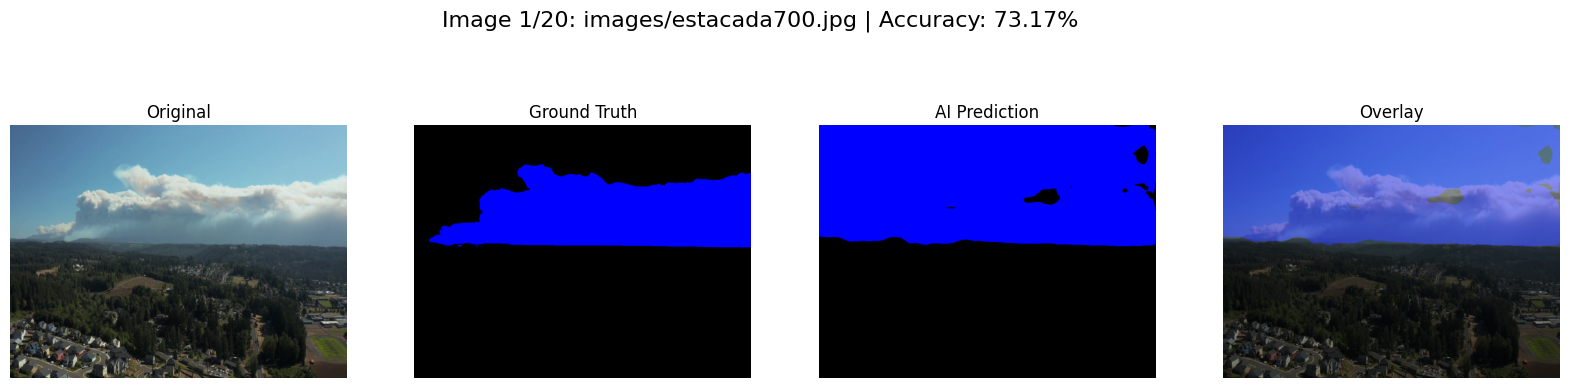

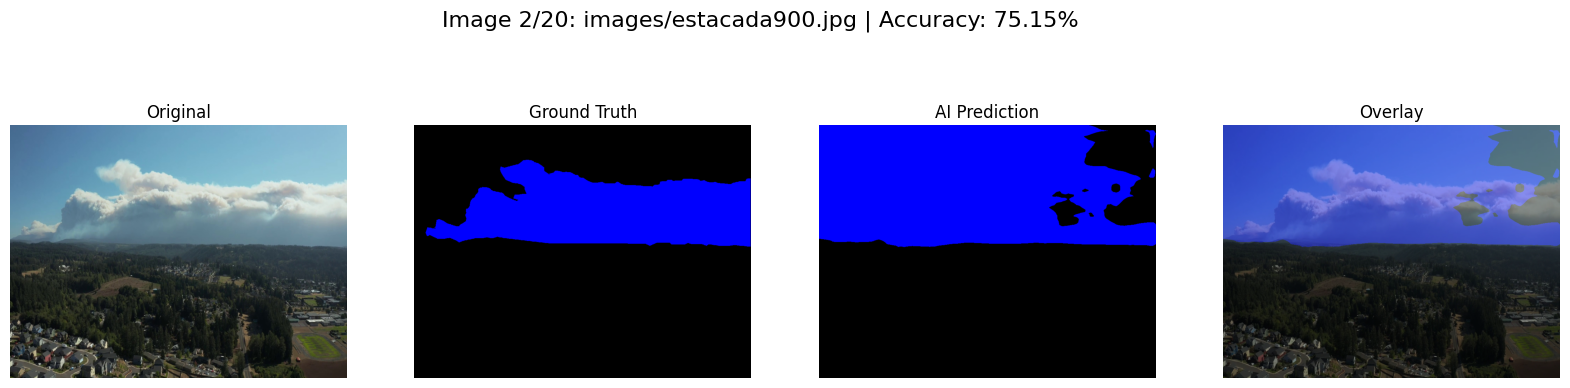

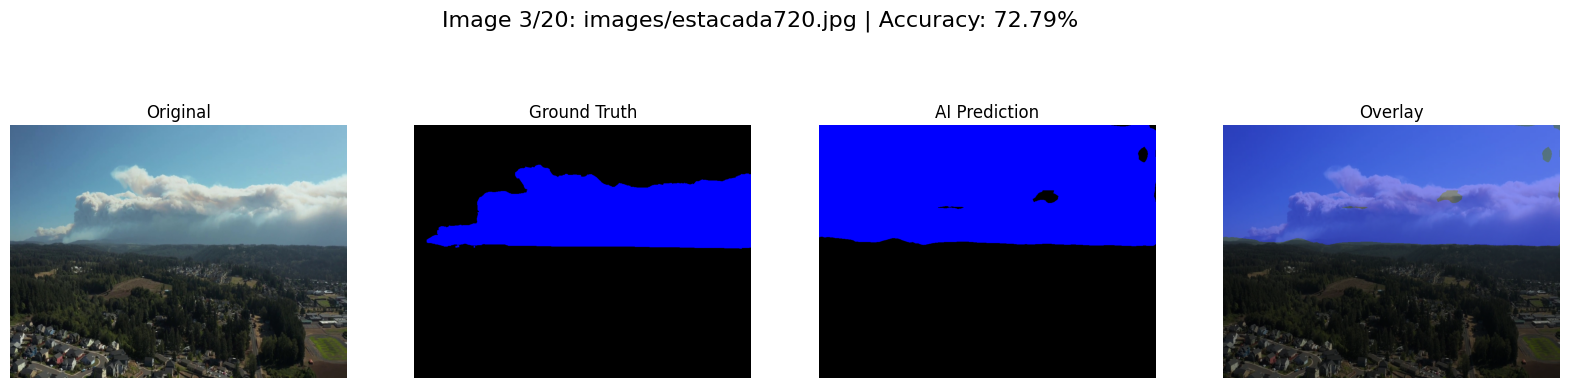

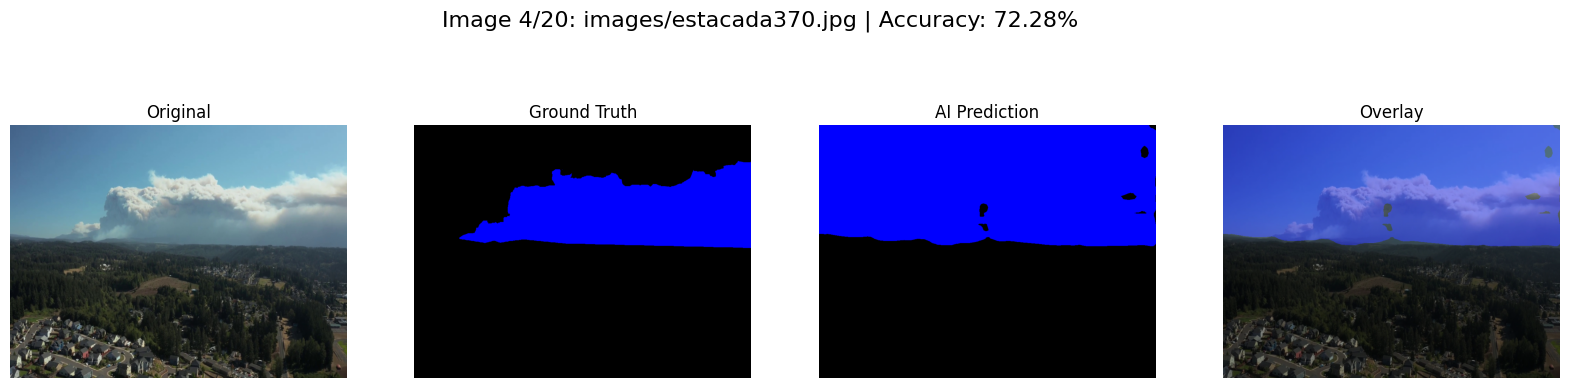

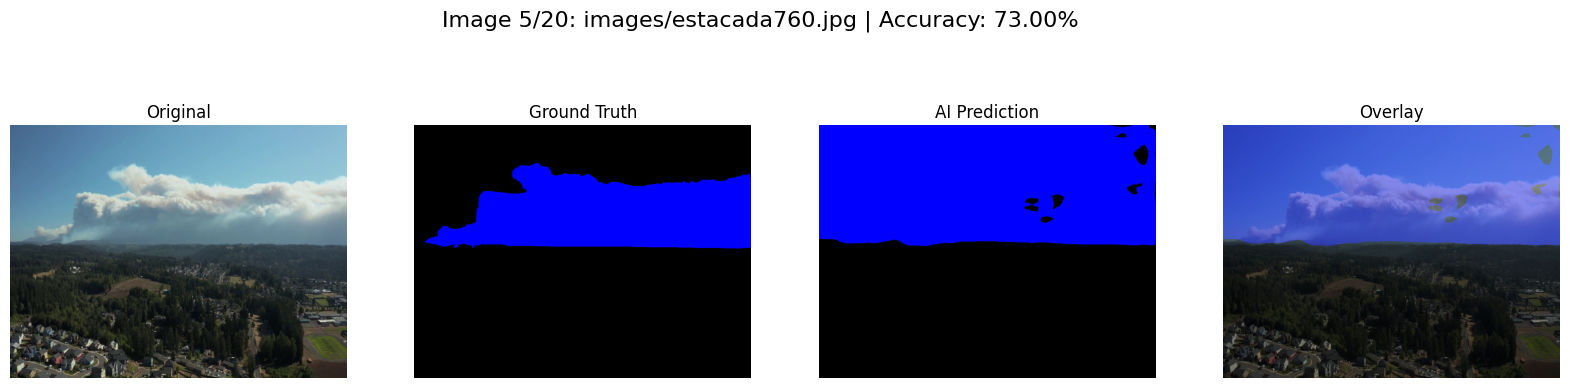

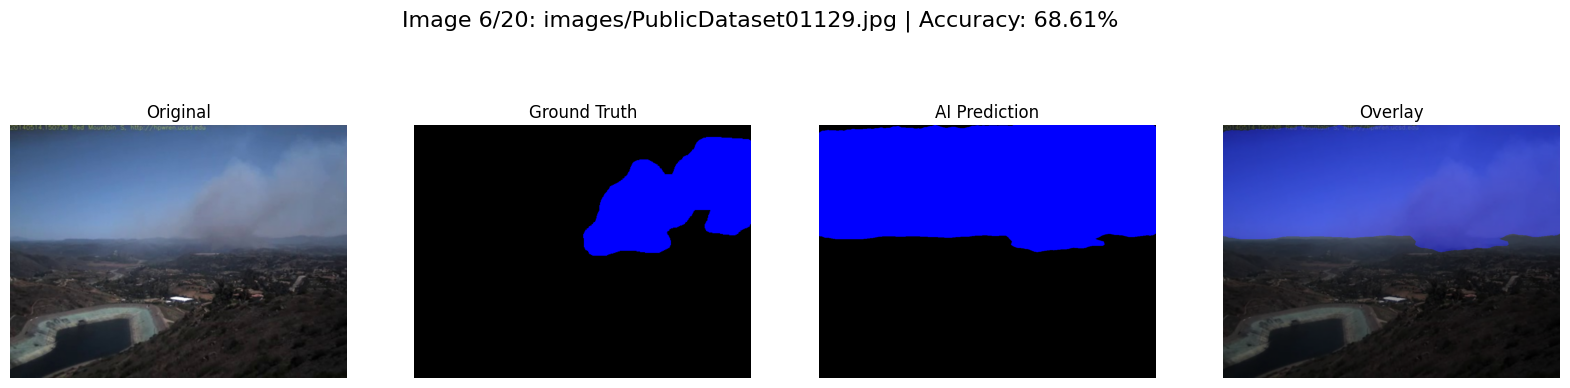

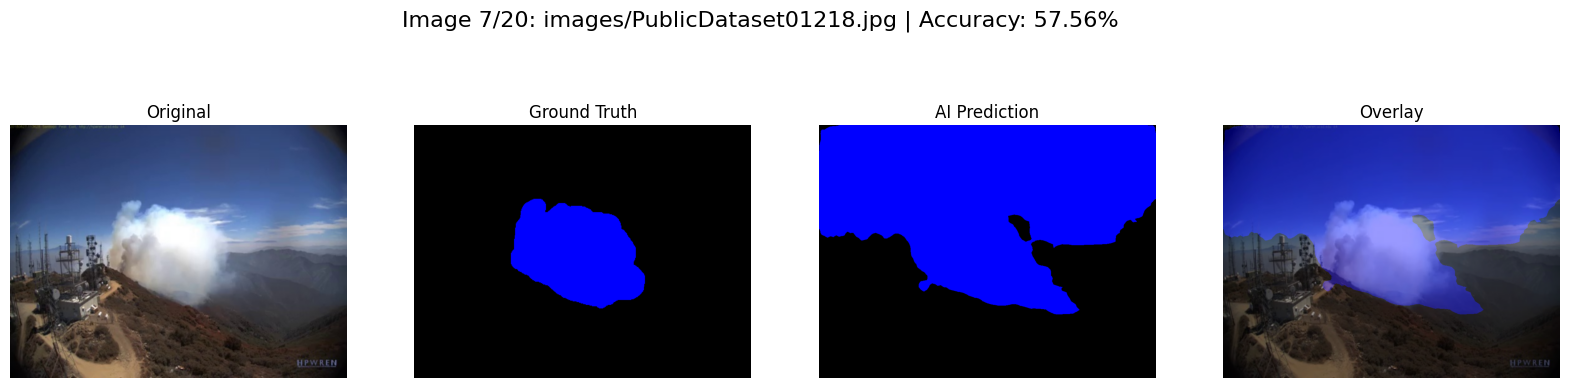

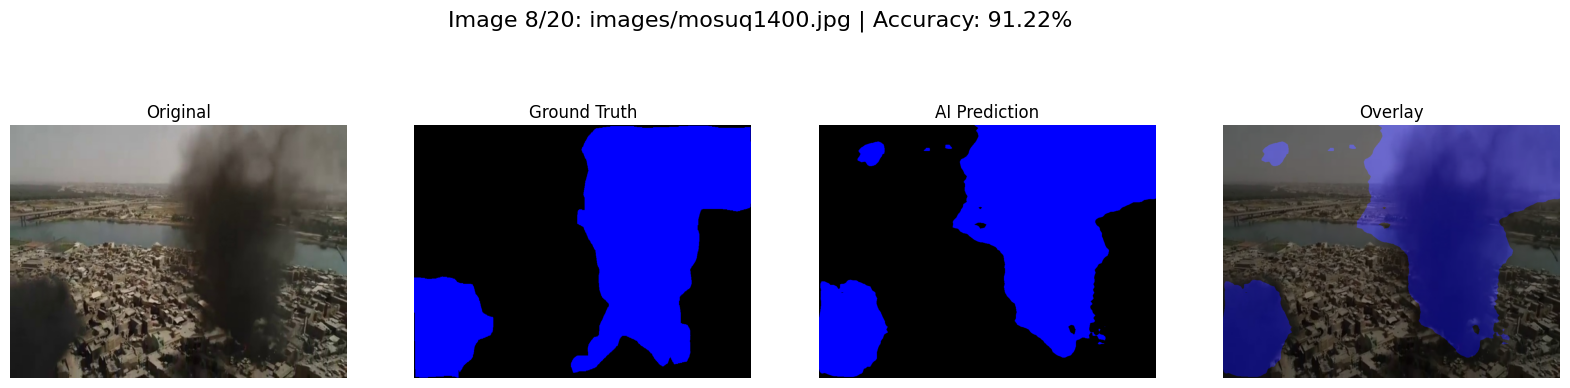

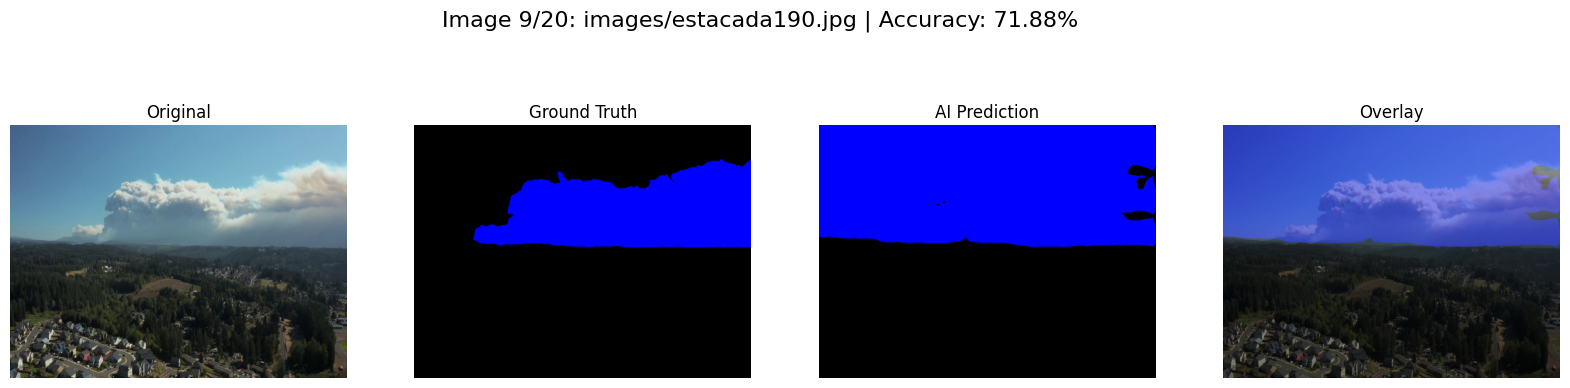

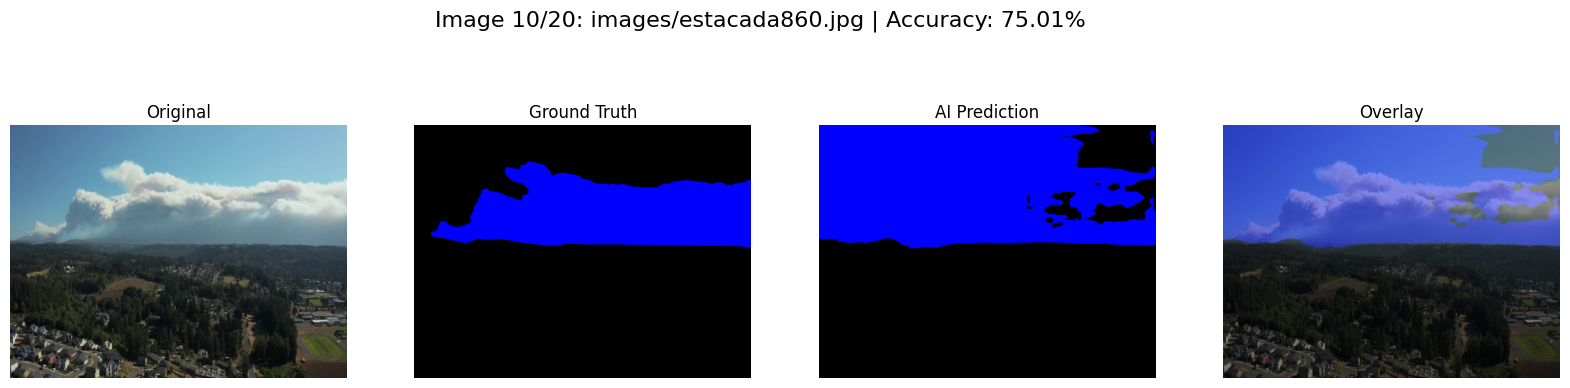

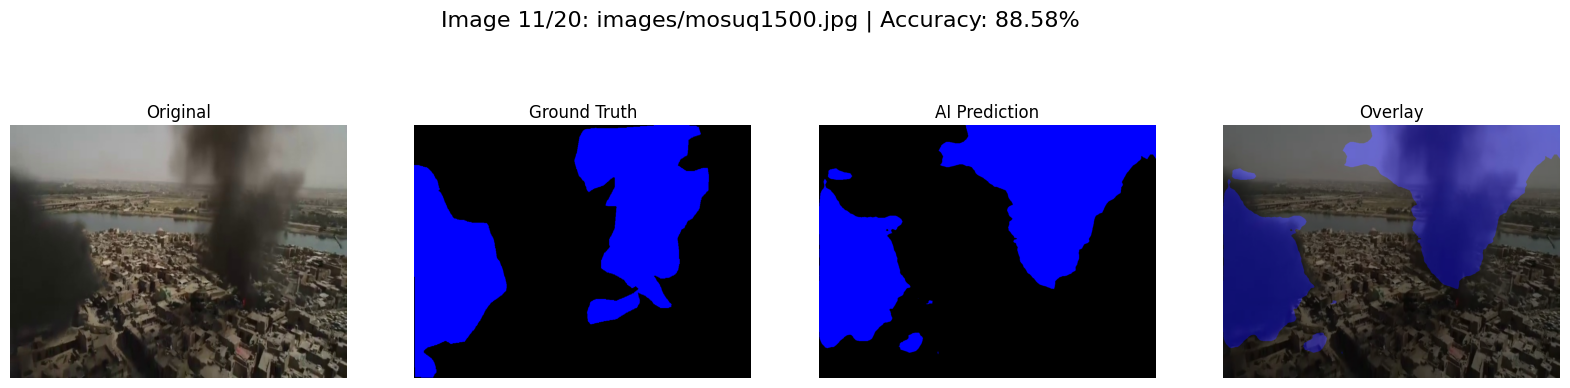

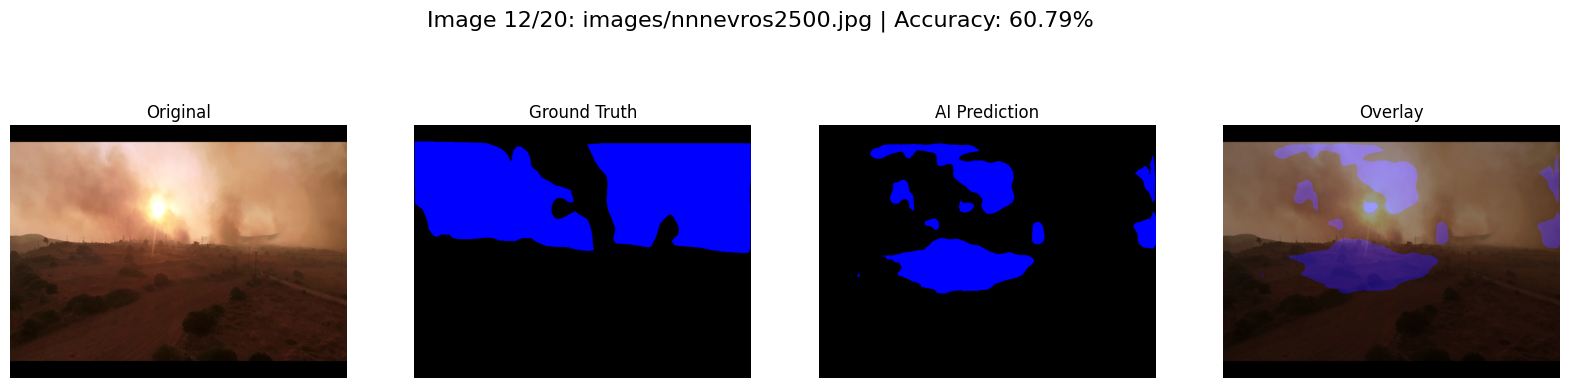

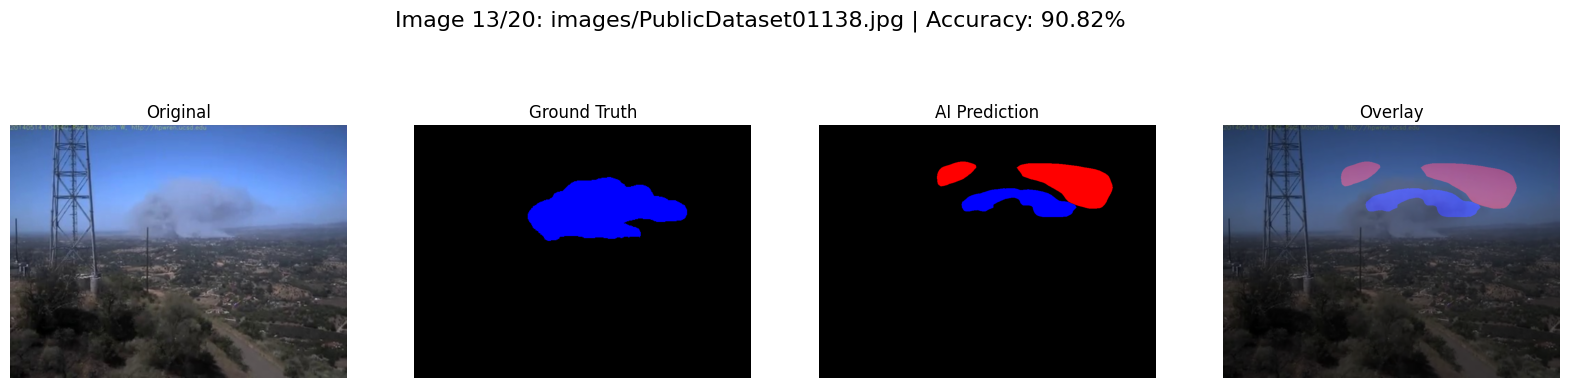

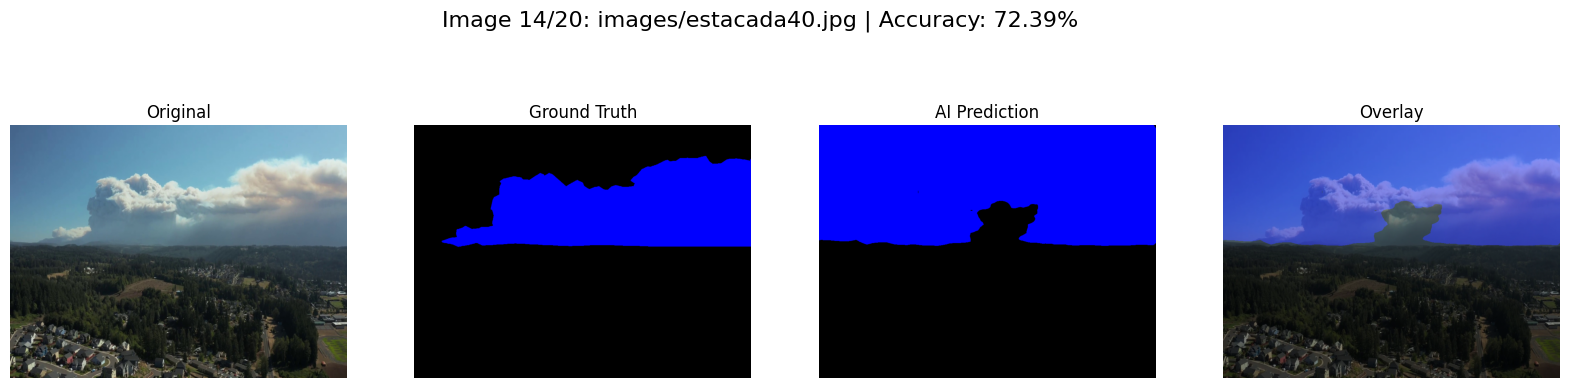

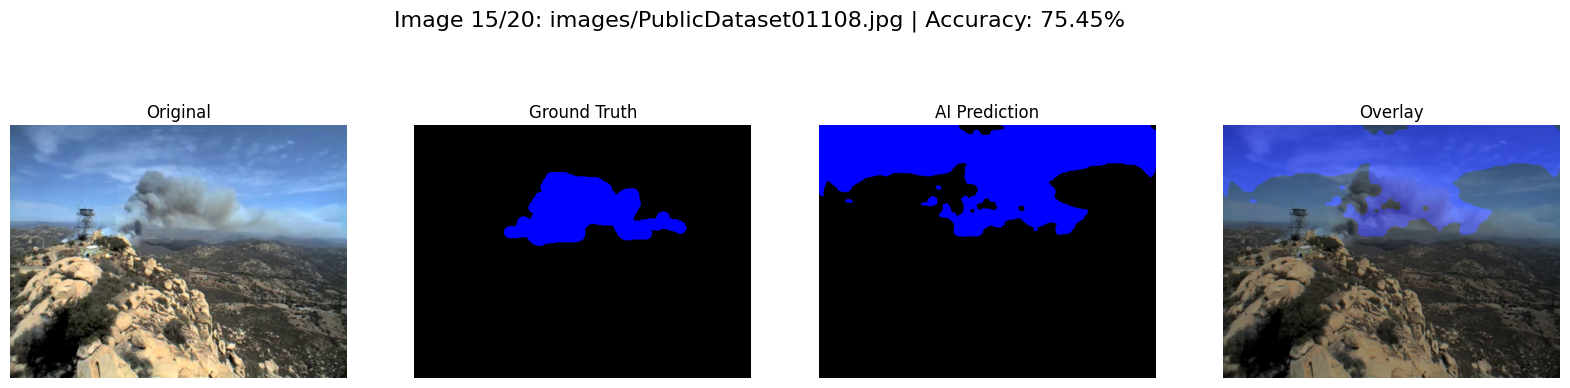

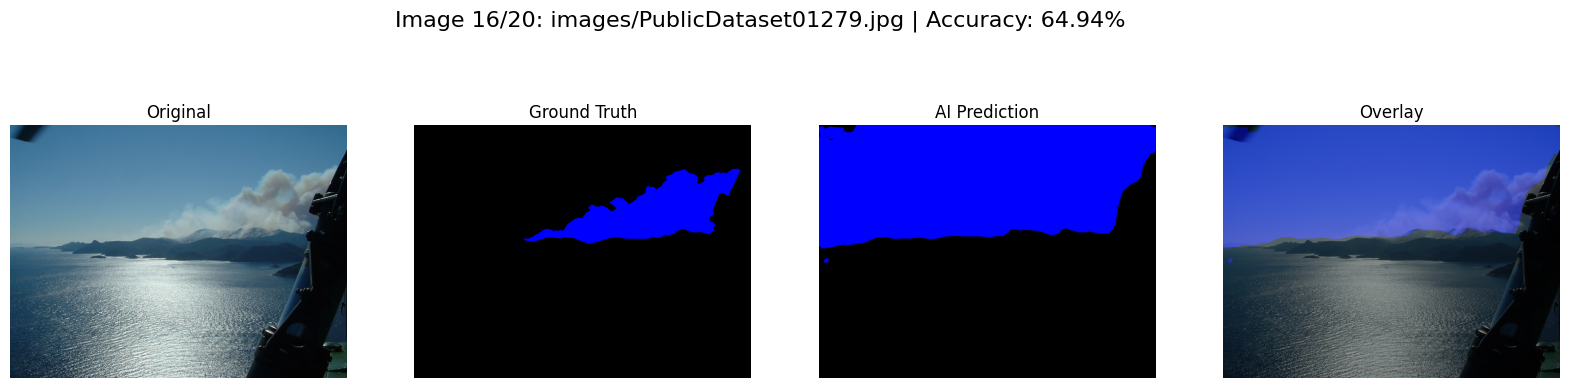

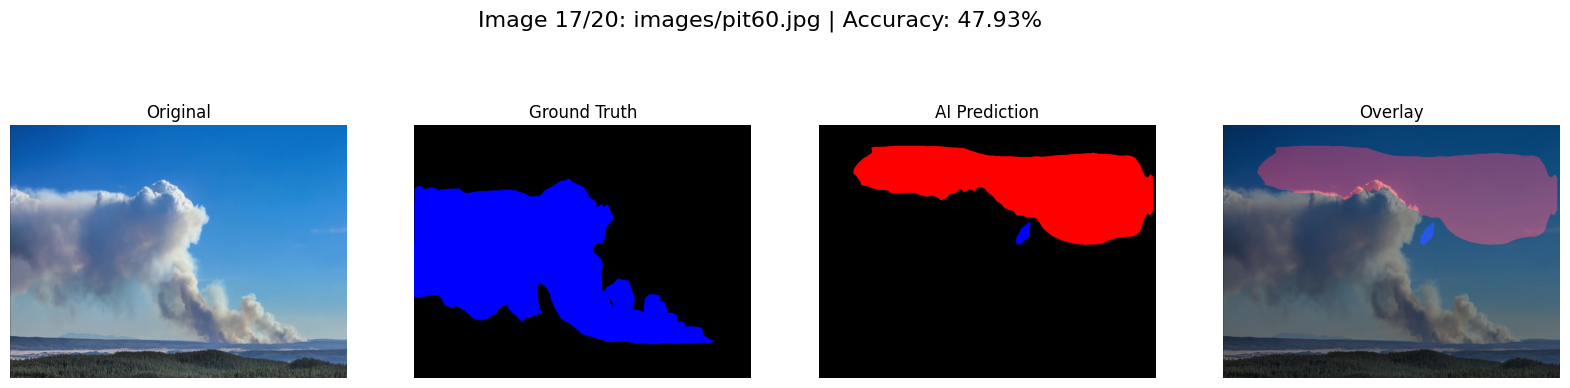

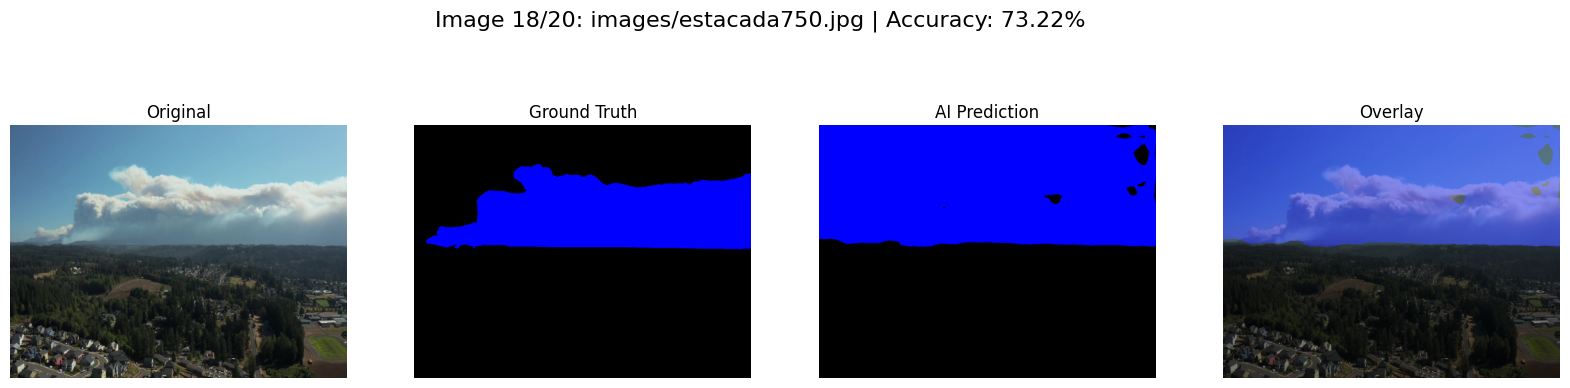

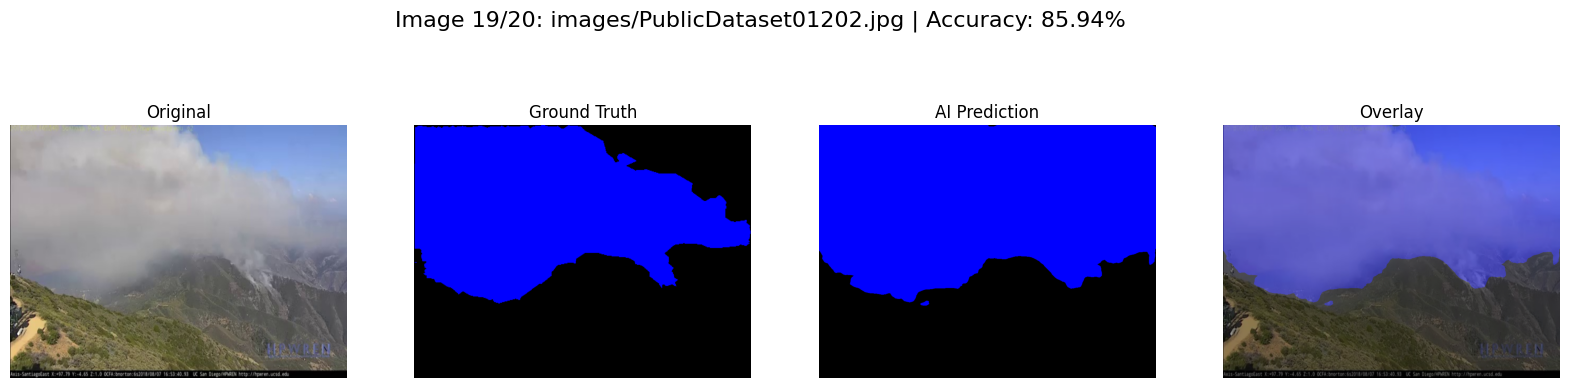

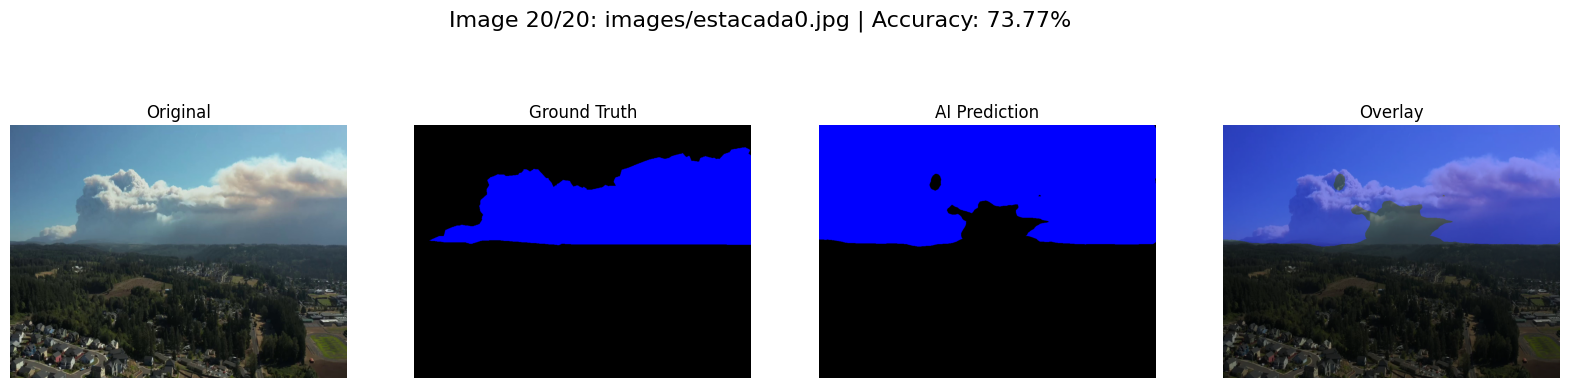

--- ΤΕΛΟΣ VALIDATION TEST ---


In [14]:
import os
import torch
import numpy as np
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from models import pidnet
from configs import config
import random

print("--- ΕΝΑΡΞΗ VALIDATION TEST (20 ΤΥΧΑΙΕΣ ΕΙΚΟΝΕΣ) ---")

# -------------------------------------------------------------------------
# 1. ΡΥΘΜΙΣΕΙΣ
# -------------------------------------------------------------------------
config.defrost()
config.DATASET.NUM_CLASSES = 4 
config.DATASET.DATASET = 'camvid'
config.MODEL.PRETRAINED = '' 
config.freeze()

model_path = 'output/camvid/pidnet_small_camvid/checkpoint.pth.tar' 
val_list_path = 'data/list/camvid/val.lst'
root_dir = 'data/camvid'

# Χρώματα: 0=Fire(Κόκκινο), 1=Smoke(Μπλε), 2=Burnt(Γκρι), 3=Background(Μαύρο)
colors = np.array([
    [255, 0, 0],    # 0: Fire
    [0, 0, 255],    # 1: Smoke
    [128, 128, 128],# 2: Burnt
    [0, 0, 0]       # 3: Background
])

# -------------------------------------------------------------------------
# 2. ΦΟΡΤΩΣΗ ΜΟΝΤΕΛΟΥ
# -------------------------------------------------------------------------
model = pidnet.get_seg_model(config, imgnet_pretrained=False)

if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location='cuda:0')
    
    # Διόρθωση κλειδιών (DataParallel fix)
    state_dict = checkpoint['state_dict']
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('model.'): new_key = k[6:] 
        else: new_key = k
        new_state_dict[new_key] = v

    model.load_state_dict(new_state_dict, strict=True)
    print(f"-> Μοντέλο φορτώθηκε (Εποχή {checkpoint['epoch']}).")
else:
    print(f"ΣΦΑΛΜΑ: Δεν βρέθηκε το {model_path}")
    exit()

model.cuda()
model.eval()

# -------------------------------------------------------------------------
# 3. ΣΥΝΑΡΤΗΣΕΙΣ
# -------------------------------------------------------------------------
def load_label_mapped(lbl_path):
    """Φορτώνει τη μάσκα και διορθώνει τις τιμές βάσει των χρωμάτων του CVAT"""
    if not os.path.exists(lbl_path): return None
    
    label = cv2.imread(lbl_path, cv2.IMREAD_GRAYSCALE)
    if label is None: return None
    
    label = cv2.resize(label, (960, 720), interpolation=cv2.INTER_NEAREST)
    
    # --- MAPPING FIX ---
    label_fixed = np.zeros_like(label) + 3 # Default: Background
    label_fixed[(label >= 70) & (label <= 85)] = 0   # Fire (76)
    label_fixed[(label >= 20) & (label <= 30)] = 1   # Smoke (24)
    label_fixed[(label >= 140) & (label <= 180)] = 2 # Burnt (147)
    
    return label_fixed.astype(np.uint8)

def preprocess_image(img_path):
    if not os.path.exists(img_path): return None, None
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None: return None, None
    
    original_vis = cv2.resize(image, (960, 720))
    original_vis = cv2.cvtColor(original_vis, cv2.COLOR_BGR2RGB)
    
    image = cv2.resize(image, (960, 720), interpolation=cv2.INTER_LINEAR)
    image = image.astype(np.float32) / 255.0
    image -= [0.485, 0.456, 0.406]
    image /= [0.229, 0.224, 0.225]
    image = image.transpose((2, 0, 1))
    
    return torch.from_numpy(image).unsqueeze(0).cuda(), original_vis

def colorize_mask(mask):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for cls_id in range(4):
        color_mask[mask == cls_id] = colors[cls_id]
    return color_mask

# -------------------------------------------------------------------------
# 4. ΕΠΙΛΟΓΗ ΚΑΙ ΕΚΤΕΛΕΣΗ (20 ΤΥΧΑΙΕΣ)
# -------------------------------------------------------------------------
with open(val_list_path, 'r') as f:
    lines = f.readlines()

# Επιλογή 20 τυχαίων εικόνων
samples_to_test = random.sample(lines, min(len(lines), 20))
print(f"Θα ελεγχθούν {len(samples_to_test)} εικόνες...\n")

for i, line in enumerate(samples_to_test):
    parts = line.strip().split()
    if len(parts) != 2: continue
    
    img_rel, lbl_rel = parts
    img_full = os.path.join(root_dir, img_rel)
    lbl_full = os.path.join(root_dir, lbl_rel)
    
    # Επεξεργασία
    input_tensor, original_img = preprocess_image(img_full)
    ground_truth = load_label_mapped(lbl_full) 
    
    if input_tensor is None: continue

    # Πρόβλεψη
    with torch.no_grad():
        output = model(input_tensor)
        if isinstance(output, (list, tuple)): pred_logits = output[1]
        else: pred_logits = output
            
        pred_logits = F.interpolate(pred_logits, size=(720, 960), mode='bilinear', align_corners=True)
        prediction = torch.argmax(pred_logits, dim=1).squeeze(0).cpu().numpy()

    # Υπολογισμός Ακρίβειας
    acc_str = "N/A"
    vis_gt = np.zeros_like(original_img)
    
    if ground_truth is not None:
        valid_pixels = (ground_truth != 255)
        correct_pixels = np.sum((prediction == ground_truth) & valid_pixels)
        total_pixels = np.sum(valid_pixels)
        acc = (correct_pixels / total_pixels) * 100 if total_pixels > 0 else 0
        acc_str = f"{acc:.2f}%"
        vis_gt = colorize_mask(ground_truth)

    vis_pred = colorize_mask(prediction)
    overlay = cv2.addWeighted(original_img, 0.6, vis_pred, 0.4, 0)

    # Εμφάνιση
    plt.figure(figsize=(20, 5))
    plt.suptitle(f"Image {i+1}/20: {img_rel} | Accuracy: {acc_str}", fontsize=16)
    
    plt.subplot(1, 4, 1); plt.imshow(original_img); plt.title("Original"); plt.axis('off')
    plt.subplot(1, 4, 2); plt.imshow(vis_gt); plt.title("Ground Truth"); plt.axis('off')
    plt.subplot(1, 4, 3); plt.imshow(vis_pred); plt.title("AI Prediction"); plt.axis('off')
    plt.subplot(1, 4, 4); plt.imshow(overlay); plt.title("Overlay"); plt.axis('off')
    plt.show()

print("--- ΤΕΛΟΣ VALIDATION TEST ---")